In [1]:
%load_ext autoreload
%autoreload 2

import torch

from pianogen.model.model import SelectiveAttnTransformer
from torch.optim import Adam
from torch import nn
from pianogen.dataset.with_feature import FeatureDataset
from pianogen.tokenizer import PianoRollTokenizer
from torch.utils.data import DataLoader
from pianogen.model.with_feature import Cake

device = 'cuda'

def move_to_device(b):
    if isinstance(b, torch.Tensor):
        return b.to(device)
    elif isinstance(b, dict):
        return {k:move_to_device(v) for k,v in b.items()}

In [3]:
model = Cake(a0_size=512, max_len=150, dim_model=256, num_layers=6, num_heads=8, dim_feedforward=1024)
model = model.to(device).train()

# ds = FeatureDataset(r'W:\music\music-data-analysis\data', loaders=model.get_loaders(), max_duration=32*150)
# dl = DataLoader(ds,batch_size=3, shuffle=True, num_workers=8)
# gradient_accumulation_steps = 3

ds = FeatureDataset(r'W:\music\music-data-analysis\data', loaders=model.get_loaders(), max_duration=32*150)
dl = DataLoader(ds,batch_size=3, shuffle=True, num_workers=8)
gradient_accumulation_steps = 3

test_data = FeatureDataset.from_midi(r'W:\music\ai_cowork_trim.mid', loaders=model.get_loaders())

Loaded 2374 samples from 2570 songs
Applying PianoRollProcessor to dataset C:\Users\User\AppData\Local\Temp\music_data_analysis_1_1_1_1_1


100%|██████████| 1/1 [00:00<00:00, 153.78it/s]


Applying DurationProcessor to dataset C:\Users\User\AppData\Local\Temp\music_data_analysis_1_1_1_1_1


100%|██████████| 1/1 [00:00<00:00, 133.22it/s]


Applying PitchProcessor to dataset C:\Users\User\AppData\Local\Temp\music_data_analysis_1_1_1_1_1


100%|██████████| 1/1 [00:00<00:00, 200.02it/s]


Applying NoteDensityProcessor to dataset C:\Users\User\AppData\Local\Temp\music_data_analysis_1_1_1_1_1


100%|██████████| 1/1 [00:00<00:00, 1061.58it/s]


Applying PolyphonyProcessor to dataset C:\Users\User\AppData\Local\Temp\music_data_analysis_1_1_1_1_1


100%|██████████| 1/1 [00:00<00:00, 333.28it/s]


Applying VelocityProcessor to dataset C:\Users\User\AppData\Local\Temp\music_data_analysis_1_1_1_1_1


100%|██████████| 1/1 [00:00<00:00, 1001.03it/s]


Applying ChordProcessor to dataset C:\Users\User\AppData\Local\Temp\music_data_analysis_1_1_1_1_1


100%|██████████| 1/1 [00:00<00:00, 95.10it/s]

Loaded 1 samples from 1 songs


In [4]:
from pathlib import Path
from torch.utils.tensorboard.writer import SummaryWriter

exp_name = 'feature/bigger_model_grad_accum_3'

output_dir = Path(f'./output/{exp_name}')
output_dir.mkdir(parents=True, exist_ok=True)
checkpoint_dir = Path(f'./checkpoint/{exp_name}')
checkpoint_dir.mkdir(parents=True, exist_ok=True)
tensorboard_dir = Path(f'./tensorboard/{exp_name}')

writer = SummaryWriter(tensorboard_dir)
opt = Adam(model.parameters(), lr=2e-4)
print('number of parameters:', sum(p.numel() for p in model.parameters())/1e6, 'M')

number of parameters: 19.572441 M


In [5]:
from_epoch = 150
epoch = from_epoch
# load from checkpoint
if from_epoch > 0:
    checkpoint = torch.load(checkpoint_dir/f'{from_epoch}.pt')
    model.load_state_dict(checkpoint['model'])
    opt.load_state_dict(checkpoint['opt'])
model = model.to(device)

In [6]:
# train
from pianogen import gpu_temp_control
from tqdm import tqdm

temp_control = gpu_temp_control.GPUTempControl(64,3)

model.to(device)

model.train()

for epoch in range(from_epoch+1,400): 
    tq = tqdm(dl)
    model.train()
    for i, batch in enumerate(tq):
        batch = move_to_device(batch)
        assert isinstance(batch, dict)
        loss = model.calculate_loss(batch)
        loss['total'].backward()

        if (i+1) % gradient_accumulation_steps == 0:
            opt.step()
            opt.zero_grad()

        temp_control.cooldown()

        if i % 10 == 0:
            # print the loss to tqdm
            tq.set_postfix(batch = i, loss= loss, gpu_temp=temp_control.get_temp())
        
        if torch.isnan(loss['total']):
            raise ValueError("Loss is NaN")

        # writer.add_scalar('loss', loss.item(), epoch*len(dl)+i)
        for k,v in loss.items():
            writer.add_scalar(f'loss_{k}', v.item(), epoch*len(dl)+i)
        writer.add_scalar('gpu_temp', temp_control.get_temp(), epoch*len(dl)+i)

    model.eval()
    model.sample_and_save(output_dir/f'output_{epoch}_{i}.mid', 16, 4)

    if epoch % 10 == 0:
        torch.save({'model':model.state_dict(), 'opt':opt.state_dict()}, checkpoint_dir/f'{epoch}.pt')
    

  0%|          | 0/792 [00:00<?, ?it/s]c:\Users\User\miniconda3\envs\gr\Lib\site-packages\torch\nn\functional.py:5504: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)
100%|██████████| 16/16 [00:09<00:00,  1.66it/s]


Generated:  ['next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['A_m', 'A_m', 'A_M', 'A_m', 'G_m7', 'E_M', 'F_M7', 'F_M7', 'F_M', 'F_M', 'F_M7', 'F_M7', 'E_m', 'E_m', 'D_m7', 'D_m7', 'F_m', 'C_M', 'G_7', 'A_m7', 'D_m', 'D_m', 'D_m', 'D_m', 'D_sus2', 'G_m7', 'A_m', 'A_m', 'E_m7', 'E_7', 'G_M', 'G_M']


100%|██████████| 16/16 [00:10<00:00,  1.55it/s]


Generated:  [{'type': 'pitch', 'value': 12}, {'type': 'velocity', 'value': 25}, 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'None', 'C_M', 'C_M', 'A_m7', 'A_m7', 'C_M7', 'C_M7', 'A_sus2', 'A_sus2', 'E_m7', 'E_m7', 'C_M', 'C_M7', 'C_M', 'C_M', 'G_7', 'G_7', 'D_M7', 'G_7', 'G_M', 'G_M', 'G_M', 'G_M', 'A_m', 'A_m', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7']


100%|██████████| 16/16 [00:09<00:00,  1.69it/s]


Generated:  ['next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['None', 'None', 'None', 'None', 'F_M', 'F_M', 'C_M', 'C_M', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'D_m7', 'E_m', 'D_m7', 'D_m7', 'D_m', 'D_m', 'A_m7', 'A_m7', 'G_M', 'G_M', 'G_M', 'G_M']


100%|██████████| 16/16 [00:10<00:00,  1.46it/s]


Generated:  [{'type': 'pitch', 'value': 19}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 43}, {'type': 'velocity', 'value': 15}, 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['A_M', 'A_M', 'G_M', 'G_M', 'C_+', 'C_+', 'F_M7', 'F_M7', 'B_o', 'F_M7', 'C_M', 'B_o', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M7', 'F_M7', 'A_m7', 'A_m7', 'A_m', 'A_m', 'G_M', 'G_M', 'G_M', 'G_M', 'F_M', 'A_m7', 'F_M', 'F_M']


100%|██████████| 16/16 [00:10<00:00,  1.56it/s]


Generated:  ['next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_sus2', 'None', 'C_sus2', 'C_sus2', 'F_M', 'F_M', 'F_M', 'F_M', 'C_M7', 'C_M7', 'C_M', 'C_M', 'F_M', 'F_M', 'F_M', 'F_M', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'F_M', 'F_M', 'F_M', 'F_M', 'D_M', 'D_M', 'None', 'None', 'C_+', 'C_+', 'F_M7', 'F_M7']


100%|██████████| 16/16 [00:08<00:00,  1.83it/s]


Generated:  [{'type': 'pitch', 'value': 12}, {'type': 'velocity', 'value': 18}, {'type': 'pitch', 'value': 24}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['None', 'None', 'None', 'None', 'A_m', 'A_m', 'A_m7', 'A_m7', 'F#_o', 'F#_o', 'D_m7', 'F#_o', 'G_M', 'G_M', 'G_M', 'G_M', 'A_m', 'A_m', 'A_m', 'A_m', 'C_M7', 'C_M7', 'C_M', 'C_M', 'F_sus2', 'F_sus2', 'F_M7', 'F_M7', 'A_m7', 'A_m7', 'A_m', 'A_m']


100%|██████████| 16/16 [00:08<00:00,  1.84it/s]


Generated:  ['next_frame', 'next_frame', {'type': 'pitch', 'value': 22}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 34}, {'type': 'velocity', 'value': 21}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['None', 'None', 'None', 'None', 'C_M', 'C_M', 'C_M', 'C_M', 'F_M7', 'F_M7', 'C_M', 'C_M', 'G_7', 'G_7', 'G_7', 'G_7', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m7', 'A_m7', 'C_M', 'C_M', 'A_m7', 'A_m7', 'D_M', 'D_M', 'D_m7', 'D_m7', 'D_m7', 'D_m7']


100%|██████████| 16/16 [00:09<00:00,  1.70it/s]


Generated:  [{'type': 'pitch', 'value': 17}, {'type': 'velocity', 'value': 21}, {'type': 'pitch', 'value': 29}, {'type': 'velocity', 'value': 22}, {'type': 'pitch', 'value': 36}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 41}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame']
Chords:  ['D_m', 'C_M', 'None', 'None', 'F_M7', 'F_M7', 'E_m7', 'E_m7', 'G_7', 'G_7', 'G_7', 'G_7', 'A_m', 'A_m', 'G_M', 'G_M', 'G_M', 'G_M', 'G_M', 'G_M', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'E_m', 'E_m', 'G_7', 'G_7', 'D_m', 'D_m', 'D_m', 'D_m']


100%|██████████| 16/16 [00:09<00:00,  1.65it/s]


Generated:  ['next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['A_m', 'A_m', 'A_m', 'A_m', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'None', 'None', 'F_M7', 'F_M7', 'A_sus4', 'A_sus4', 'C_M', 'C_M', 'F_M7', 'F_M7', 'G_M', 'G_M', 'C_M', 'C_M', 'C_M7', 'C_M7', 'G_7', 'G_7', 'G_7', 'G_7', 'D_M', 'D_M', 'D_M', 'D_M']


100%|██████████| 16/16 [00:07<00:00,  2.06it/s]


Generated:  [{'type': 'pitch', 'value': 20}, {'type': 'velocity', 'value': 10}, {'type': 'pitch', 'value': 32}, {'type': 'velocity', 'value': 12}, {'type': 'pitch', 'value': 36}, {'type': 'velocity', 'value': 12}, {'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 9}, 'next_frame', 'next_frame']
Chords:  ['C_M', 'C_M', 'C_M', 'C_M', 'F_M7', 'F_M7', 'G_7', 'G_7', 'D_m7', 'A_m', 'D_m7', 'D_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'E_M', 'E_M', 'E_M', 'E_M', 'F_M', 'F_M', 'F_M', 'F_M', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'E_7', 'E_7', 'A_m', 'A_m']


100%|██████████| 16/16 [00:07<00:00,  2.03it/s]


Generated:  ['next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m', 'A_m', 'A_m', 'A_m', 'D_m7', 'D_m7', 'A_m7', 'A_m7', 'D_m7', 'D_m7', 'D_m7', 'D_m7', 'G_M', 'G_M', 'A_m', 'A_m', 'C_M', 'C_M', 'C_M', 'C_M', 'G_M', 'G_M', 'G_M', 'G_M', 'A_m7', 'A_m7', 'A_m7', 'A_m7']


100%|██████████| 16/16 [00:07<00:00,  2.09it/s]


Generated:  ['next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['A_m', 'A_m', 'A_m', 'A_m', 'G_M', 'G_M', 'G_M', 'G_M', 'F_M7', 'F_M7', 'C_M', 'C_M', 'C_M7', 'C_M7', 'C_M', 'C_M', 'A_m', 'A_m', 'A_m7', 'A_m7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_sus4', 'A_m7', 'G_7', 'G_7', 'G_M', 'G_M', 'G_M', 'G_M']


100%|██████████| 16/16 [00:08<00:00,  1.97it/s]


Generated:  [{'type': 'pitch', 'value': 24}, {'type': 'velocity', 'value': 19}, {'type': 'pitch', 'value': 36}, {'type': 'velocity', 'value': 19}, {'type': 'pitch', 'value': 60}, {'type': 'velocity', 'value': 23}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['F_M', 'F_M', 'F_M', 'F_M', 'C_M', 'C_M', 'C_M', 'C_M', 'A_m7', 'A_m7', 'C_M', 'C_M', 'D_m7', 'D_m7', 'E_M', 'E_M', 'C_M', 'C_M', 'C_M7', 'C_M7', 'G_M', 'G_M', 'G_7', 'G_7', 'A_m', 'A_m', 'A_m', 'A_m', 'E_M', 'E_M', 'A_m7', 'A_m7']


100%|██████████| 16/16 [00:08<00:00,  1.96it/s]


Generated:  ['next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['None', 'None', 'None', 'None', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m7', 'A_m7', 'F#_o', 'F#_o', 'F#_o', 'F#_o', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M7', 'F_M7', 'F_M', 'F_M']


100%|██████████| 16/16 [00:07<00:00,  2.07it/s]


Generated:  [{'type': 'pitch', 'value': 24}, {'type': 'velocity', 'value': 14}, {'type': 'pitch', 'value': 43}, {'type': 'velocity', 'value': 16}, {'type': 'pitch', 'value': 48}, {'type': 'velocity', 'value': 16}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M', 'C_M', 'F_M7', 'F_M7', 'C_M7', 'C_M7', 'F_M', 'F_M', 'C_M7', 'C_M7', 'E_m7', 'E_m7', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M', 'C_M', 'F_M7', 'F_M7', 'C_M', 'C_M', 'C_M', 'C_M', 'C_sus2', 'C_sus2', 'F_M', 'F_M', 'D_m7', 'D_m7', 'D_m7', 'D_m7']


100%|██████████| 16/16 [00:09<00:00,  1.77it/s]


Generated:  [{'type': 'pitch', 'value': 36}, {'type': 'velocity', 'value': 18}, 'next_frame', 'next_frame', {'type': 'pitch', 'value': 43}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', {'type': 'pitch', 'value': 48}, {'type': 'velocity', 'value': 18}]
Chords:  ['None', 'None', 'F_M7', 'F_M7', 'C_+', 'C_+', 'E_M', 'E_M', 'G_7', 'G_7', 'C_M7', 'C_M7', 'F_M', 'F_M', 'F_M7', 'F_M7', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M', 'C_M', 'C_M', 'C_M']


100%|██████████| 16/16 [00:08<00:00,  1.81it/s]


Generated:  [{'type': 'pitch', 'value': 27}, {'type': 'velocity', 'value': 11}, {'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 14}, {'type': 'pitch', 'value': 43}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 46}, {'type': 'velocity', 'value': 17}, 'next_frame', 'next_frame']
Chords:  ['None', 'None', 'None', 'None', 'A_M', 'A_M', 'A_M7', 'A_M7', 'F_M7', 'F_M7', 'C_M7', 'C_M7', 'F_M7', 'F_M7', 'C_M7', 'C_M7', 'A_m', 'A_m', 'A_m', 'A_m', 'C_M7', 'C_M7', 'G_M', 'G_M', 'F_M7', 'F_M7', 'G_7', 'G_7', 'A_m', 'A_m', 'A_m', 'A_m']


100%|██████████| 16/16 [00:08<00:00,  1.88it/s]


Generated:  [{'type': 'pitch', 'value': 22}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 29}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 34}, {'type': 'velocity', 'value': 16}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['A_m', 'A_m', 'A_m7', 'A_m7', 'F_sus2', 'F_sus2', 'F_sus2', 'F_sus2', 'G#_M', 'G#_M', 'A#_7', 'A#_7', 'F_M', 'F_M', 'C_M', 'C_M', 'G_M', 'G_M', 'G_M', 'G_M', 'E_m7', 'E_m7', 'E_m7', 'E_m7', 'A_m', 'A_m', 'A_m', 'A_m', 'F_M7', 'F_M7', 'F_M7', 'F_M7']


100%|██████████| 16/16 [00:08<00:00,  1.98it/s]


Generated:  ['next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['None', 'None', 'None', 'None', 'F_sus2', 'F_sus2', 'F_M7', 'F_M7', 'E_7', 'E_7', 'A_m', 'A_m', 'G_m7', 'G_m7', 'G_M', 'G_M', 'G_M', 'G_M', 'E_m7', 'E_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M7', 'F_M7', 'C_M', 'C_M', 'C_M', 'C_M']


100%|██████████| 16/16 [00:07<00:00,  2.02it/s]


Generated:  [{'type': 'pitch', 'value': 15}, {'type': 'velocity', 'value': 19}, {'type': 'pitch', 'value': 27}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame', {'type': 'pitch', 'value': 43}, {'type': 'velocity', 'value': 18}]
Chords:  ['A_M', 'A_M', 'A_M', 'A_M', 'C_M7', 'C_M7', 'G_7', 'G_7', 'D_m7', 'D_m7', 'D_m7', 'D_m7', 'G_7', 'G_7', 'G_M', 'G_M', 'F_M', 'F_M', 'F_M', 'F_M', 'G_7', 'G_7', 'G_M', 'G_M', 'A_m', 'A_m', 'A_m', 'A_m', 'A_M', 'A_M', 'D_m7', 'D_m7']


100%|██████████| 16/16 [00:07<00:00,  2.07it/s]


Generated:  ['next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['G_M', 'G_M', 'E_m7', 'E_m7', 'E_m7', 'E_m7', 'E_m7', 'E_m7', 'A_m', 'A_m', 'A_m', 'A_m', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'F_M', 'F_M', 'G_7', 'G_7', 'A_M', 'A_M', 'A_M', 'A_M', 'None', 'None', 'None', 'None']


100%|██████████| 16/16 [00:07<00:00,  2.09it/s]


Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 14}, {'type': 'pitch', 'value': 46}, {'type': 'velocity', 'value': 13}, 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', {'type': 'pitch', 'value': 51}]
Chords:  ['None', 'None', 'D_m7', 'D_m7', 'C_M', 'C_M', 'C_M', 'C_M', 'D_m7', 'D_m7', 'G_M', 'G_M', 'F_M', 'F_M', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m', 'A_m', 'A_m7', 'A_m7', 'E_m7', 'E_m7', 'C_M', 'C_M', 'G_M', 'G_M', 'G_M', 'G_M']


100%|██████████| 16/16 [00:07<00:00,  2.19it/s]


Generated:  ['next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'E_m7', 'E_m7', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'B_o', 'B_o', 'A_m', 'A_m', 'C_M', 'C_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M', 'C_M', 'F_M7', 'F_M7', 'F_M7', 'F_M7']


100%|██████████| 16/16 [00:07<00:00,  2.04it/s]


Generated:  [{'type': 'pitch', 'value': 19}, {'type': 'velocity', 'value': 12}, {'type': 'pitch', 'value': 26}, {'type': 'velocity', 'value': 12}, {'type': 'pitch', 'value': 31}, {'type': 'velocity', 'value': 11}, {'type': 'pitch', 'value': 35}, {'type': 'velocity', 'value': 13}, 'next_frame', 'next_frame']
Chords:  ['None', 'None', 'None', 'None', 'C_M', 'C_M', 'C_M', 'C_M', 'A_m7', 'A_m7', 'C_M', 'C_M', 'D_m7', 'D_m7', 'G_M', 'G_M', 'C_M', 'C_M', 'G_M', 'G_M', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'G_M', 'G_M', 'G_M', 'G_M', 'G_M', 'G_M', 'G_M', 'G_M']


100%|██████████| 16/16 [00:07<00:00,  2.24it/s]


Generated:  ['next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['None', 'None', 'None', 'None', 'C_M', 'C_M', 'C_M', 'C_M', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m7', 'A_m7', 'F_M7', 'F_M7', 'F_M', 'F_M', 'G_M', 'G_M', 'C_M', 'C_M', 'C_M7', 'C_M7']


100%|██████████| 16/16 [00:06<00:00,  2.43it/s]


Generated:  ['next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M', 'C_M', 'C_M7', 'C_M7', 'None', 'None', 'None', 'None', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'C_M', 'C_M', 'C_M', 'C_M']


100%|██████████| 16/16 [00:08<00:00,  1.92it/s]


Generated:  [{'type': 'pitch', 'value': 31}, {'type': 'velocity', 'value': 19}, {'type': 'pitch', 'value': 59}, {'type': 'velocity', 'value': 19}, {'type': 'pitch', 'value': 62}, {'type': 'velocity', 'value': 22}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['A_M', 'A_M', 'A_M7', 'A_M7', 'A_M', 'A_M', 'A_m', 'A_m', 'F_M', 'F_M', 'F_M7', 'F_M7', 'F_sus2', 'F_sus2', 'F_sus2', 'F_sus2', 'C_M', 'C_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M', 'C_M', 'G_7', 'G_7', 'G_M', 'G_M', 'C_M', 'C_M', 'E_m7', 'E_m7']


100%|██████████| 16/16 [00:07<00:00,  2.17it/s]


Generated:  [{'type': 'pitch', 'value': 20}, {'type': 'velocity', 'value': 13}, {'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 14}, {'type': 'pitch', 'value': 46}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 48}, {'type': 'velocity', 'value': 15}, 'next_frame', 'next_frame']
Chords:  ['None', 'None', 'None', 'None', 'A_m', 'A_m', 'G_M', 'G_M', 'A_m7', 'A_m7', 'A_m', 'A_m', 'F_m', 'F_m', 'F_m', 'F_m', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'C_M', 'C_M', 'C_M', 'C_M', 'F_M', 'F_M', 'None', 'None', 'D_m', 'D_m', 'D_m7', 'D_m7']


100%|██████████| 16/16 [00:07<00:00,  2.18it/s]


Generated:  [{'type': 'pitch', 'value': 12}, {'type': 'velocity', 'value': 18}, {'type': 'pitch', 'value': 24}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 36}, {'type': 'velocity', 'value': 22}, {'type': 'pitch', 'value': 48}, {'type': 'velocity', 'value': 22}, 'next_frame', 'next_frame']
Chords:  ['None', 'None', 'None', 'None', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'D_m7', 'D_m7', 'D_m7', 'D_m7', 'E_m7', 'E_m7', 'None', 'None', 'None', 'None', 'F_M7', 'F_M7', 'E_M', 'E_M', 'E_7', 'E_7', 'A_m', 'A_m', 'F_M7', 'F_M7', 'G_M', 'G_M', 'G_M', 'G_M']


100%|██████████| 16/16 [00:07<00:00,  2.08it/s]


Generated:  ['next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'E_7', 'E_7', 'A_m', 'A_m', 'C_M', 'C_M', 'C_M', 'C_M', 'E_M', 'E_M', 'E_M', 'E_M', 'E_m', 'E_m', 'E_m', 'E_m', 'C_M', 'C_M', 'E_m7', 'E_m7', 'C_M', 'C_M', 'C_M', 'C_M']


100%|██████████| 16/16 [00:06<00:00,  2.38it/s]


Generated:  [{'type': 'pitch', 'value': 12}, {'type': 'velocity', 'value': 19}, {'type': 'pitch', 'value': 24}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 36}, {'type': 'velocity', 'value': 18}, {'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 19}, {'type': 'pitch', 'value': 43}, {'type': 'velocity', 'value': 20}]
Chords:  ['None', 'None', 'A_m', 'A_m', 'F_M7', 'F_M7', 'A_m7', 'A_m7', 'E_o', 'E_o', 'C_M', 'C_M', 'G_sus2', 'G_sus2', 'G_+', 'G_+', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'D_m', 'D_m', 'D_m7', 'D_m7', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'F_M', 'F_M', 'G_M', 'G_M']


100%|██████████| 16/16 [00:07<00:00,  2.10it/s]


Generated:  [{'type': 'pitch', 'value': 24}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 31}, {'type': 'velocity', 'value': 13}, {'type': 'pitch', 'value': 36}, {'type': 'velocity', 'value': 14}, {'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 43}, {'type': 'velocity', 'value': 14}]
Chords:  ['None', 'None', 'E_m7', 'E_m7', 'A_m', 'A_m', 'A_m', 'A_m', 'C_M7', 'C_M7', 'A_m', 'A_m', 'A_m7', 'A_m7', 'D_m7', 'D_m7', 'C_M', 'C_M', 'C_M', 'C_M', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'D_m7', 'D_m7', 'C_M7', 'C_M7']


100%|██████████| 16/16 [00:07<00:00,  2.21it/s]


Generated:  ['next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M', 'C_M', 'C_M', 'C_M', 'G_7', 'G_7', 'D_m7', 'D_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'A_sus4', 'A_sus4', 'A_m', 'A_m', 'G_M', 'G_M', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'G_M', 'G_M', 'G_M', 'G_M', 'B_o', 'B_o', 'B_o', 'B_o']


100%|██████████| 16/16 [00:07<00:00,  2.20it/s]


Generated:  ['next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['None', 'None', 'C_M7', 'C_M7', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'E_m7', 'E_m7', 'E_m7', 'E_m7', 'A_M', 'A_M', 'A_M7', 'A_M7', 'A_m', 'A_m', 'C_M7', 'C_M7', 'C_M', 'C_M', 'C_M', 'C_M', 'A#_M', 'A#_M', 'A#_M', 'A#_M']


100%|██████████| 16/16 [00:07<00:00,  2.20it/s]


Generated:  [{'type': 'pitch', 'value': 36}, {'type': 'velocity', 'value': 19}, {'type': 'pitch', 'value': 48}, {'type': 'velocity', 'value': 19}, 'next_frame', 'next_frame', 'next_frame', 'next_frame', {'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}]
Chords:  ['None', 'None', 'None', 'None', 'E_m7', 'E_m7', 'A_m', 'A_m', 'C_M', 'C_M', 'C_M', 'C_M', 'None', 'None', 'G_7', 'G_7', 'F_M7', 'F_M7', 'C_+', 'C_+', 'F_sus2', 'F_sus2', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M7', 'C_M7', 'C_M', 'C_M', 'C_M', 'C_M']


100%|██████████| 16/16 [00:07<00:00,  2.24it/s]


Generated:  ['next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['None', 'None', 'C_M7', 'C_M7', 'C_M', 'C_M', 'A_m7', 'A_m7', 'F_M7', 'F_M7', 'C_+', 'C_+', 'E_m7', 'E_m7', 'E_m7', 'E_m7', 'A_m', 'A_m', 'A_m', 'A_m', 'D_M', 'G_M', 'E_m7', 'E_m7', 'E_m', 'E_m', 'E_M', 'E_M', 'A_M', 'A_M', 'A_M', 'A_M']


100%|██████████| 16/16 [00:07<00:00,  2.27it/s]


Generated:  ['next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['A_m', 'A_m', 'D_m7', 'D_m7', 'A_m7', 'A_m7', 'C_M7', 'C_M7', 'F_M', 'F_M', 'C_M', 'C_M', 'C_M', 'C_M', 'G_M', 'G_M', 'A_m7', 'A_m7', 'G_M', 'G_M', 'F_M', 'F_M', 'C_M7', 'C_M7', 'C_M', 'C_M', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7']


100%|██████████| 16/16 [00:07<00:00,  2.20it/s]


Generated:  [{'type': 'pitch', 'value': 20}, {'type': 'velocity', 'value': 16}, {'type': 'pitch', 'value': 32}, {'type': 'velocity', 'value': 18}, {'type': 'pitch', 'value': 48}, {'type': 'velocity', 'value': 18}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 56}, {'type': 'velocity', 'value': 18}]
Chords:  ['F_M7', 'F_M7', 'F_M7', 'F_M7', 'C_M', 'C_M', 'C_M7', 'C_M7', 'D_m7', 'D_m7', 'D_m7', 'D_m7', 'E_M', 'E_M', 'E_M', 'E_M', 'E_m7', 'E_m7', 'E_m7', 'E_m7', 'A_m', 'A_m', 'A_m', 'A_m', 'C_M7', 'C_M7', 'G_7', 'G_7', 'C_M', 'C_M', 'C_M', 'C_M']


100%|██████████| 16/16 [00:07<00:00,  2.11it/s]


Generated:  [{'type': 'pitch', 'value': 34}, {'type': 'velocity', 'value': 14}, {'type': 'pitch', 'value': 41}, {'type': 'velocity', 'value': 16}, {'type': 'pitch', 'value': 50}, {'type': 'velocity', 'value': 16}, {'type': 'pitch', 'value': 53}, {'type': 'velocity', 'value': 18}, {'type': 'pitch', 'value': 58}, {'type': 'velocity', 'value': 17}]
Chords:  ['A_m', 'A_m', 'A_m', 'A_m', 'F_M', 'F_M', 'F_M', 'F_M', 'A_sus4', 'A_sus4', 'A_m7', 'A_m7', 'A_m', 'A_m', 'A_m7', 'A_m7', 'E_7', 'E_7', 'E_7', 'E_7', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'F_M7', 'F_M7', 'F_M7', 'F_M7']


100%|██████████| 16/16 [00:07<00:00,  2.28it/s]


Generated:  [{'type': 'pitch', 'value': 27}, {'type': 'velocity', 'value': 19}, {'type': 'pitch', 'value': 43}, {'type': 'velocity', 'value': 19}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['E_m7', 'E_m7', 'E_m7', 'E_m7', 'A_m7', 'A_m7', 'A_m', 'A_m', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'G_sus2', 'G_sus2', 'G_M', 'G_M', 'C_M', 'C_M', 'E_m7', 'E_m7', 'F_M7', 'F_M7', 'F_M', 'F_M', 'None', 'None', 'None', 'None']


100%|██████████| 16/16 [00:07<00:00,  2.27it/s]


Generated:  [{'type': 'pitch', 'value': 27}, {'type': 'velocity', 'value': 18}, {'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 18}, {'type': 'pitch', 'value': 43}, {'type': 'velocity', 'value': 18}, {'type': 'pitch', 'value': 46}, {'type': 'velocity', 'value': 18}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 19}]
Chords:  ['C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M7', 'C_M7', 'G_7', 'G_7', 'None', 'None', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M7', 'C_M7', 'C_M', 'C_M', 'A_m', 'A_m', 'A_m', 'A_m', 'None', 'None', 'None', 'None', 'C_M', 'C_M', 'C_M', 'C_M']


100%|██████████| 16/16 [00:07<00:00,  2.16it/s]


Generated:  ['next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['A_m', 'A_m', 'C_M', 'C_M', 'D_m7', 'D_m7', 'C_M', 'C_M', 'A_m', 'A_m', 'A_m7', 'A_m7', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M', 'C_M', 'C_M', 'C_M', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'A_m7', 'A_m7', 'F_M7', 'F_M7', 'D_m', 'D_m', 'D_m', 'D_m']


100%|██████████| 16/16 [00:06<00:00,  2.34it/s]


Generated:  [{'type': 'pitch', 'value': 32}, {'type': 'velocity', 'value': 13}, {'type': 'pitch', 'value': 48}, {'type': 'velocity', 'value': 13}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 16}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['A_m', 'A_m', 'F_M7', 'F_M7', 'E_m7', 'E_m7', 'E_7', 'E_7', 'C_M', 'C_M', 'C_M', 'C_M', 'A_M', 'A_M', 'A_M7', 'A_M7', 'G_M', 'G_M', 'G_M', 'G_M', 'F_M', 'F_M', 'F_M', 'F_M', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'C_M', 'C_M', 'A_m', 'A_m']


100%|██████████| 16/16 [00:07<00:00,  2.07it/s]


Generated:  [{'type': 'pitch', 'value': 27}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 46}, {'type': 'velocity', 'value': 19}, 'next_frame', 'next_frame', 'next_frame', 'next_frame', {'type': 'pitch', 'value': 34}, {'type': 'velocity', 'value': 15}]
Chords:  ['F_M7', 'F_M7', 'A_m7', 'A_m7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'F_M7', 'F_M7', 'C_M7', 'C_M7', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M', 'C_M', 'C_M', 'C_M', 'F_M', 'F_M', 'G_M', 'G_M', 'E_M', 'E_M', 'E_M7', 'E_M7', 'C_M', 'C_M', 'F_M7', 'F_M7']


100%|██████████| 16/16 [00:07<00:00,  2.26it/s]


Generated:  [{'type': 'pitch', 'value': 12}, {'type': 'velocity', 'value': 18}, {'type': 'pitch', 'value': 24}, {'type': 'velocity', 'value': 19}, {'type': 'pitch', 'value': 36}, {'type': 'velocity', 'value': 18}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['None', 'None', 'None', 'None', 'E_m7', 'E_m7', 'G_7', 'G_7', 'D_m7', 'D_m7', 'D_m7', 'D_m7', 'A_m', 'A_m', 'A_m7', 'A_m7', 'G_M', 'G_M', 'G_M', 'G_M', 'A_m', 'A_m', 'None', 'None', 'A_m', 'A_m', 'E_m', 'E_m', 'F_M7', 'F_M7', 'G_M', 'G_M']


100%|██████████| 16/16 [00:07<00:00,  2.21it/s]


Generated:  ['next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['A_M', 'A_M', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'A_M', 'A_M', 'A_M', 'A_M', 'None', 'None', 'None', 'None', 'F_M', 'F_M', 'None', 'None', 'A_m', 'A_m', 'A_m', 'A_m', 'E_m7', 'E_m7', 'E_m7', 'E_m7', 'C_M', 'C_M', 'C_M', 'C_M']


100%|██████████| 16/16 [00:06<00:00,  2.34it/s]


Generated:  ['next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['None', 'None', 'None', 'None', 'A_m7', 'A_m7', 'C_M7', 'C_M7', 'None', 'None', 'None', 'None', 'A_m7', 'A_m7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M', 'C_M', 'G_M', 'G_M', 'A_m', 'A_m', 'A_m', 'A_m']


100%|██████████| 16/16 [00:07<00:00,  2.08it/s]


Generated:  ['next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['A_m7', 'A_m7', 'A_m7', 'A_m7', 'G_M', 'G_M', 'G_M', 'G_M', 'F_M7', 'F_M7', 'G_7', 'G_7', 'F_M', 'F_M', 'F_M', 'F_M', 'C_M', 'C_M', 'C_M7', 'C_M7', 'G_7', 'G_7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'E_m7', 'E_m7', 'F_M', 'F_M', 'D_m7', 'D_m7']


100%|██████████| 16/16 [00:07<00:00,  2.17it/s]


Generated:  [{'type': 'pitch', 'value': 24}, {'type': 'velocity', 'value': 16}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 21}, 'next_frame', 'next_frame', 'next_frame', 'next_frame', {'type': 'pitch', 'value': 31}, {'type': 'velocity', 'value': 16}]
Chords:  ['A_m7', 'A_m7', 'F_M7', 'F_M7', 'D_o', 'D_o', 'E_7', 'E_7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'C_M7', 'C_M7', 'A_m', 'A_m', 'D_m7', 'D_m7', 'F_M', 'F_M', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'C_M', 'C_M', 'A_m', 'A_m', 'F_M7', 'F_M7']


100%|██████████| 16/16 [00:07<00:00,  2.04it/s]


Generated:  [{'type': 'pitch', 'value': 36}, {'type': 'velocity', 'value': 16}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['None', 'None', 'None', 'None', 'D_M', 'A_M', 'A_M', 'A_M', 'E_m7', 'E_m7', 'E_m7', 'E_m7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'E_m', 'E_m', 'C_M', 'C_M', 'F_M', 'F_M', 'G_M', 'G_M', 'C_M', 'C_M', 'C_M', 'C_M', 'A_m7', 'A_m7', 'D_m7', 'D_m7']


100%|██████████| 16/16 [00:07<00:00,  2.25it/s]


Generated:  [{'type': 'pitch', 'value': 22}, {'type': 'velocity', 'value': 18}, {'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 19}, {'type': 'pitch', 'value': 43}, {'type': 'velocity', 'value': 18}, {'type': 'pitch', 'value': 46}, {'type': 'velocity', 'value': 19}, 'next_frame', 'next_frame']
Chords:  ['None', 'None', 'None', 'None', 'None', 'None', 'F_M', 'F_M', 'None', 'None', 'A_M', 'A_M', 'F_M', 'F_M', 'F_M', 'F_M', 'None', 'None', 'None', 'None', 'E_m7', 'E_m7', 'C_+', 'C_+', 'C_M', 'C_M', 'C_M', 'C_M', 'A_m7', 'A_m7', 'A_m7', 'A_m7']


100%|██████████| 16/16 [00:07<00:00,  2.05it/s]


Generated:  ['next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['None', 'None', 'None', 'None', 'F_M', 'F_M', 'F_M', 'F_M', 'F_M', 'F_M', 'F_M', 'F_M', 'C_M', 'C_M', 'C_M', 'C_M', 'F_M', 'F_M', 'F_M', 'F_M', 'C_M', 'C_M', 'F_M7', 'F_M7', 'F_M', 'F_M', 'C_M', 'G_M', 'D_m7', 'D_m7', 'D_m7', 'D_m7']


100%|██████████| 16/16 [00:07<00:00,  2.08it/s]


Generated:  [{'type': 'pitch', 'value': 36}, {'type': 'velocity', 'value': 12}, {'type': 'pitch', 'value': 43}, {'type': 'velocity', 'value': 13}, {'type': 'pitch', 'value': 48}, {'type': 'velocity', 'value': 12}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, 'next_frame', 'next_frame']
Chords:  ['A_m7', 'A_m7', 'None', 'None', 'G_M', 'G_M', 'E_m7', 'E_m7', 'C_M', 'C_M', 'C_M', 'C_M', 'A_M', 'A_M', 'A_M', 'A_M', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'E_M', 'A_m', 'A_m', 'A_m', 'D_m7', 'D_m7', 'G_7', 'G_7', 'A_m7', 'A_m7', 'A_m7', 'A_m7']


100%|██████████| 16/16 [00:07<00:00,  2.20it/s]


Generated:  ['next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['A_m', 'A_m', 'D_m7', 'D_m7', 'F_M', 'F_M', 'C_M7', 'C_M7', 'G_7', 'G_7', 'G_7', 'G_7', 'A_m', 'A_m', 'A_m', 'A_m', 'D_m7', 'D_m7', 'E_m7', 'E_m7', 'G_m7', 'C_M', 'A_m', 'A_m', 'G_M', 'G_M', 'G_M', 'G_M', 'E_m', 'E_m', 'A_m', 'A_m']


100%|██████████| 16/16 [00:06<00:00,  2.31it/s]


Generated:  ['next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M', 'C_M', 'C_M', 'C_M', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'E_m', 'E_m', 'A#_M', 'A#_M', 'A#_M', 'A#_M', 'C_M', 'C_M', 'C_M', 'C_M', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m7', 'A_m7', 'A_M', 'A_M']


100%|██████████| 16/16 [00:07<00:00,  2.19it/s]


Generated:  [{'type': 'pitch', 'value': 15}, {'type': 'velocity', 'value': 19}, {'type': 'pitch', 'value': 27}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 46}, {'type': 'velocity', 'value': 21}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['D_m7', 'D_m7', 'F_M', 'F_M', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'D_m7', 'D_m7', 'D_m7', 'D_m7', 'D_m', 'D_m', 'D_m', 'D_m', 'B_o', 'B_o', 'D_m7', 'D_m7', 'A_m', 'A_m', 'A_m', 'A_m', 'G_7', 'G_7', 'B_o', 'B_o', 'F_M', 'F_M', 'F_M7', 'F_M7']


100%|██████████| 16/16 [00:07<00:00,  2.20it/s]


Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 16}, {'type': 'pitch', 'value': 46}, {'type': 'velocity', 'value': 14}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 18}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['F_M', 'F_M', 'F_M', 'F_M', 'D_M', 'D_M', 'D_sus2', 'D_sus2', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'None', 'None', 'None', 'None', 'A_m7', 'A_m7', 'D_m7', 'D_m7', 'F_M', 'F_M', 'G_7', 'G_7', 'C_M', 'C_M', 'C_M', 'C_M', 'F_M7', 'F_M7', 'F_M', 'F_M']


100%|██████████| 16/16 [00:07<00:00,  2.15it/s]


Generated:  [{'type': 'pitch', 'value': 20}, {'type': 'velocity', 'value': 18}, 'next_frame', 'next_frame', {'type': 'pitch', 'value': 27}, {'type': 'velocity', 'value': 17}, 'next_frame', 'next_frame', {'type': 'pitch', 'value': 32}, {'type': 'velocity', 'value': 18}]
Chords:  ['None', 'None', 'None', 'None', 'F_M', 'F_M', 'F_M', 'F_M', 'E_m7', 'E_m7', 'E_m7', 'E_m7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'D_m7', 'D_m7', 'G_M', 'G_M', 'F_M7', 'F_M7', 'A_m', 'A_m', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M7', 'C_M7']


100%|██████████| 16/16 [00:07<00:00,  2.15it/s]


Generated:  ['next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M', 'C_M', 'C_M7', 'C_M7', 'A_m', 'A_m', 'A_m', 'A_m', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'F_m', 'F_m', 'F_m7', 'F_m7', 'F_M', 'F_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'A_M', 'A_M', 'A_M7', 'A_M7']


100%|██████████| 16/16 [00:07<00:00,  2.22it/s]


Generated:  ['next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M', 'C_M', 'A_m7', 'A_m7', 'G_M', 'G_M', 'G_M', 'G_M', 'F_M', 'F_M', 'G_M', 'G_M', 'F_M', 'F_M', 'F_M', 'F_M', 'C_M', 'C_M', 'C_M', 'C_M', 'D_m', 'D_m', 'G_7', 'G_7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'None', 'None', 'None', 'None']


100%|██████████| 16/16 [00:07<00:00,  2.08it/s]


Generated:  ['next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['None', 'None', 'None', 'None', 'F_sus2', 'F_sus2', 'F_M', 'F_M', 'F_M', 'F_M', 'F_M', 'F_M', 'C_M', 'C_M', 'C_M', 'C_M', 'E_o', 'E_o', 'C_M', 'C_M', 'A_m', 'A_m', 'A_m', 'A_m', 'C_M', 'C_M', 'C_M', 'C_M', 'A_m', 'A_m', 'A_m7', 'A_m7']


100%|██████████| 16/16 [00:07<00:00,  2.22it/s]


Generated:  [{'type': 'pitch', 'value': 72}, {'type': 'velocity', 'value': 18}, 'next_frame', 'next_frame', 'next_frame', 'next_frame', {'type': 'pitch', 'value': 48}, {'type': 'velocity', 'value': 12}, 'next_frame', 'next_frame']
Chords:  ['F_M', 'F_M', 'F_M', 'F_M', 'C_M', 'C_M', 'D_m7', 'D_m7', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'D_m', 'D_m', 'D_m', 'D_m', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m', 'A_m', 'D_m7', 'D_m7', 'D_m7', 'D_m7']


100%|██████████| 16/16 [00:07<00:00,  2.13it/s]


Generated:  [{'type': 'pitch', 'value': 12}, {'type': 'velocity', 'value': 23}, {'type': 'pitch', 'value': 24}, {'type': 'velocity', 'value': 24}, 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['E_m7', 'E_m7', 'E_m7', 'E_m7', 'A_m7', 'A_m7', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'D_m7', 'D_m7', 'F_M', 'F_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M', 'C_M', 'G_M', 'G_M', 'F_M7', 'F_M7', 'E_m7', 'E_m7', 'F_M7', 'F_M7', 'F_M7', 'F_M7']


100%|██████████| 16/16 [00:08<00:00,  1.86it/s]


Generated:  [{'type': 'pitch', 'value': 20}, {'type': 'velocity', 'value': 13}, {'type': 'pitch', 'value': 32}, {'type': 'velocity', 'value': 16}, 'next_frame', 'next_frame', 'next_frame', 'next_frame', {'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 18}]
Chords:  ['None', 'None', 'A_m', 'A_m', 'C_M', 'C_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m', 'A_m', 'A_m7', 'A_m7', 'A_m', 'A_m', 'A_m', 'A_m', 'A_M', 'A_M', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'None', 'None', 'None', 'None']


100%|██████████| 16/16 [00:07<00:00,  2.12it/s]


Generated:  [{'type': 'pitch', 'value': 8}, {'type': 'velocity', 'value': 18}, {'type': 'pitch', 'value': 20}, {'type': 'velocity', 'value': 19}, {'type': 'pitch', 'value': 44}, {'type': 'velocity', 'value': 18}, {'type': 'pitch', 'value': 48}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame']
Chords:  ['C_M', 'C_M', 'C_M', 'C_M', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'E_M', 'E_M', 'E_M', 'E_M', 'None', 'None', 'None', 'None', 'C_M', 'C_M', 'C_M', 'C_M', 'C_7', 'C_7', 'C_7', 'C_7', 'F_M', 'F_M', 'G_M', 'G_M', 'F_M7', 'F_M7', 'C_M', 'C_M']


100%|██████████| 16/16 [00:07<00:00,  2.10it/s]


Generated:  [{'type': 'pitch', 'value': 12}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 43}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 21}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['None', 'None', 'A_m7', 'A_m7', 'G_7', 'G_7', 'C_M7', 'C_M7', 'None', 'None', 'None', 'None', 'G_M', 'G_M', 'G_M', 'G_M', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'C_M', 'C_M', 'F_M7', 'F_M7', 'C_M', 'C_M', 'C_M', 'C_M', 'A_m', 'A_m', 'A_m', 'A_m']


100%|██████████| 16/16 [00:07<00:00,  2.23it/s]


Generated:  [{'type': 'pitch', 'value': 12}, {'type': 'velocity', 'value': 18}, {'type': 'pitch', 'value': 24}, {'type': 'velocity', 'value': 19}, {'type': 'pitch', 'value': 43}, {'type': 'velocity', 'value': 18}, {'type': 'pitch', 'value': 48}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 22}]
Chords:  ['None', 'None', 'None', 'None', 'F_sus2', 'F_sus2', 'E_m7', 'E_m7', 'C_M', 'C_M', 'C_M', 'C_M', 'E_M', 'E_M', 'E_7', 'E_7', 'F_M', 'F_M', 'F_M', 'F_M', 'F_M', 'F_M', 'F_M', 'F_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7']


100%|██████████| 16/16 [00:07<00:00,  2.19it/s]


Generated:  ['next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['F_M7', 'F_M7', 'F_M7', 'F_M7', 'C_M', 'C_M', 'F_M7', 'F_M7', 'E_m7', 'A_m7', 'A_m7', 'A_m7', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M', 'C_M', 'C_M7', 'C_M7', 'D_m', 'D_m', 'D_m', 'D_m', 'None', 'None', 'None', 'None', 'E_m7', 'E_m7', 'C_M', 'C_M']


100%|██████████| 16/16 [00:07<00:00,  2.21it/s]


Generated:  ['next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['F_M', 'F_M', 'F_M', 'F_M', 'F_M7', 'F_M7', 'C_M', 'C_M', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'D_m', 'D_m', 'A_m', 'A_m', 'C_M', 'C_M', 'C_M7', 'C_M7', 'None', 'None', 'A_m7', 'A_m7', 'E_m7', 'E_m7', 'E_m7', 'E_m7']


100%|██████████| 16/16 [00:07<00:00,  2.28it/s]


Generated:  [{'type': 'pitch', 'value': 48}, {'type': 'velocity', 'value': 11}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 12}, 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', {'type': 'pitch', 'value': 60}]
Chords:  ['C_M7', 'C_M7', 'A_m7', 'A_m7', 'None', 'None', 'A_m7', 'A_m7', 'F_M7', 'F_M7', 'F_M', 'F_M', 'A_M7', 'A_M7', 'A_M', 'A_M', 'G_M', 'G_M', 'G_M', 'G_M', 'E_m7', 'E_m7', 'E_m7', 'E_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'D_m', 'D_m', 'D_m', 'D_m']


100%|██████████| 16/16 [00:07<00:00,  2.15it/s]


Generated:  [{'type': 'pitch', 'value': 20}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 19}, 'next_frame', 'next_frame', 'next_frame', 'next_frame', {'type': 'pitch', 'value': 27}, {'type': 'velocity', 'value': 16}]
Chords:  ['None', 'None', 'None', 'None', 'F_m', 'F_m', 'F_m', 'F_m', 'None', 'None', 'F_M7', 'F_M7', 'E_m7', 'E_m7', 'E_m7', 'E_m7', 'G_M', 'G_M', 'G_M', 'G_M', 'F_M7', 'F_M7', 'G_7', 'G_7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m', 'A_m', 'A_m', 'A_m']


100%|██████████| 16/16 [00:07<00:00,  2.25it/s]


Generated:  ['next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['F_M', 'F_M', 'F_M', 'F_M', 'F_M7', 'F_M7', 'F_M', 'F_M', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'D_m7', 'D_m7', 'F_M7', 'F_M7', 'G_7', 'G_7', 'A_m7', 'A_m7', 'G_7', 'G_7', 'G_M', 'G_M', 'G_sus4', 'G_sus4', 'G_M', 'G_M', 'A_m7', 'A_m7', 'C_M', 'C_M']


100%|██████████| 16/16 [00:07<00:00,  2.11it/s]


Generated:  [{'type': 'pitch', 'value': 15}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 34}, {'type': 'velocity', 'value': 19}, {'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 18}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M', 'C_M', 'C_M', 'C_M', 'F_M', 'F_M', 'F_M', 'F_M', 'A_m7', 'A_m7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'D_M', 'D_M', 'D_M', 'D_M', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'C_M7', 'C_M7', 'G_M', 'G_M', 'B_o', 'F_M', 'B_o', 'B_o']


100%|██████████| 16/16 [00:07<00:00,  2.02it/s]


Generated:  ['next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M', 'C_M', 'C_sus2', 'C_sus2', 'C_M', 'C_M', 'G_M', 'G_M', 'F_M', 'F_M', 'G_M', 'G_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m', 'A_m', 'A_m', 'A_m', 'D_m7', 'D_m7', 'C_M7', 'C_M7', 'A_m', 'A_m', 'A_m7', 'A_m7']


100%|██████████| 16/16 [00:07<00:00,  2.27it/s]


Generated:  [{'type': 'pitch', 'value': 27}, {'type': 'velocity', 'value': 19}, 'next_frame', 'next_frame', 'next_frame', 'next_frame', {'type': 'pitch', 'value': 34}, {'type': 'velocity', 'value': 16}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 18}]
Chords:  ['C_M', 'C_M', 'C_M', 'C_M', 'G_M', 'G_M', 'G_M', 'G_M', 'F_M', 'F_M', 'C_M', 'C_M', 'A_m7', 'A_m7', 'C_M7', 'C_M7', 'G_M', 'G_M', 'G_M', 'G_M', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M7', 'F_M7', 'C_M7', 'C_M7']


100%|██████████| 16/16 [00:07<00:00,  2.08it/s]


Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 14}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 67}, {'type': 'velocity', 'value': 19}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m7', 'A_m7', 'E_m7', 'E_m7', 'None', 'None', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m', 'A_m', 'D_m7', 'D_m7', 'E_m7', 'E_m7', 'A_m', 'A_m', 'D_m', 'D_m', 'D_m', 'D_m']


100%|██████████| 16/16 [00:07<00:00,  2.24it/s]


Generated:  ['next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['A_M', 'A_M', 'A_M', 'A_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'G_M', 'G_M', 'G_M', 'G_M', 'F_M', 'F_M', 'F_M', 'F_M', 'F_M', 'F_M', 'F_M', 'F_M', 'None', 'None', 'A_m', 'A_m']


100%|██████████| 16/16 [00:07<00:00,  2.07it/s]


Generated:  [{'type': 'pitch', 'value': 27}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame', {'type': 'pitch', 'value': 34}, {'type': 'velocity', 'value': 18}, {'type': 'pitch', 'value': 46}, {'type': 'velocity', 'value': 18}]
Chords:  ['None', 'None', 'None', 'None', 'E_M', 'E_M', 'None', 'None', 'A_m', 'A_m', 'A_m', 'A_m', 'F_M7', 'F_M7', 'F_M', 'C_M', 'D_m7', 'D_m7', 'D_m', 'D_m', 'C_M', 'C_M', 'C_M', 'C_M', 'None', 'None', 'None', 'None', 'F_M7', 'F_M7', 'F_M7', 'F_M7']


100%|██████████| 16/16 [00:06<00:00,  2.29it/s]


Generated:  ['next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', {'type': 'pitch', 'value': 24}, {'type': 'velocity', 'value': 17}]
Chords:  ['C_M', 'C_M', 'G_M', 'G_M', 'G_M', 'G_M', 'A_m7', 'A_m7', 'E_7', 'E_7', 'E_7', 'E_7', 'D_m7', 'D_m7', 'E_M', 'E_M', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'None', 'None', 'A_m', 'A_m', 'D_M', 'D_M', 'A_M', 'A_M', 'F_M7', 'F_M7', 'F_M7', 'F_M7']


100%|██████████| 16/16 [00:07<00:00,  2.16it/s]


Generated:  [{'type': 'pitch', 'value': 12}, {'type': 'velocity', 'value': 14}, {'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 16}, {'type': 'pitch', 'value': 43}, {'type': 'velocity', 'value': 19}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['G_M', 'G_M', 'G_M', 'G_M', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'D_m7', 'D_m7', 'F_M7', 'F_M7', 'E_M', 'E_M', 'E_M', 'E_M', 'C_M', 'C_M', 'None', 'None', 'G_7', 'G_7', 'G_7', 'G_7', 'C_M7', 'C_M7', 'G_M', 'G_M', 'A_m', 'A_m', 'G_M', 'G_M']


100%|██████████| 16/16 [00:07<00:00,  2.00it/s]


Generated:  ['next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M7', 'C_M7', 'G_7', 'G_7', 'E_m7', 'E_m7', 'C_M', 'C_M', 'G_M', 'G_M', 'F_M', 'F_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'F_M7', 'F_M7', 'E_m7', 'E_m7', 'E_m7', 'E_m7', 'A_m7', 'A_m7', 'E_m', 'E_m']


100%|██████████| 16/16 [00:07<00:00,  2.06it/s]


Generated:  ['next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['None', 'None', 'None', 'None', 'None', 'None', 'E_m', 'E_m', 'G_M', 'G_M', 'None', 'None', 'G_M', 'G_M', 'G_M', 'G_M', 'F_M7', 'F_M7', 'D_m7', 'C_M', 'D_m7', 'D_m7', 'B_o', 'B_o', 'C_M', 'C_M', 'C_M', 'C_M', 'E_m', 'E_m', 'C_M7', 'C_M7']


100%|██████████| 16/16 [00:06<00:00,  2.33it/s]


Generated:  ['next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M', 'C_M', 'C_M', 'C_M', 'F_M', 'F_M', 'F_M7', 'F_M7', 'A_m7', 'A_m7', 'C_M', 'C_M', 'E_m7', 'E_m7', 'A_m', 'A_m', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_M', 'A_M', 'A_M', 'A_M', 'F_M', 'F_M', 'C_M7', 'C_M7', 'C_M', 'C_M', 'C_M7', 'C_M7']


100%|██████████| 16/16 [00:07<00:00,  2.10it/s]


Generated:  ['next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['A_M', 'A_M', 'A_M', 'A_M', 'F_M7', 'F_M7', 'G_7', 'G_7', 'E_o', 'E_o', 'C_M', 'C_M', 'A_m', 'A_m', 'F_M', 'F_M', 'E_m', 'E_m', 'A_m', 'A_m', 'C_M7', 'C_M7', 'F_M7', 'F_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'C_M7', 'C_M7', 'C_M7', 'C_M7']


100%|██████████| 16/16 [00:07<00:00,  2.22it/s]


Generated:  ['next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['E_m', 'E_m', 'A_m7', 'A_m7', 'F_M7', 'F_M7', 'E_m7', 'E_m7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'None', 'None', 'F_M', 'F_M', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'F_M', 'F_M', 'F_M', 'F_M', 'F_M', 'F_M', 'None', 'None', 'C_M7', 'C_M7', 'C_M7', 'C_M7']


100%|██████████| 16/16 [00:07<00:00,  2.23it/s]


Generated:  ['next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['A_m', 'A_m', 'A_m', 'A_m', 'F_M', 'F_M', 'F_sus2', 'F_sus2', 'F_M', 'F_M', 'F_M7', 'F_M7', 'G_M', 'G_M', 'C_M', 'C_M', 'F_M7', 'F_M7', 'F_M', 'F_M', 'G_M', 'G_M', 'A_m7', 'A_m7', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M', 'C_M', 'C_M', 'C_M']


100%|██████████| 16/16 [00:07<00:00,  2.19it/s]


Generated:  ['next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['None', 'None', 'None', 'None', 'F_M7', 'F_M7', 'F_M', 'F_M', 'A_M', 'A_M', 'A_m7', 'A_m7', 'G_M', 'G_M', 'G_M', 'G_M', 'A_m', 'A_m', 'A_m7', 'A_m7', 'E_M', 'E_M', 'E_M', 'E_M', 'E_m', 'E_m', 'E_m', 'E_m', 'E_o', 'A_m7', 'E_o', 'E_o']


100%|██████████| 16/16 [00:07<00:00,  2.09it/s]


Generated:  ['next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['None', 'None', 'None', 'None', 'C_M', 'C_M', 'C_M', 'C_M', 'A_sus2', 'A_sus2', 'A_m', 'A_m', 'D_m7', 'D_m7', 'F_M7', 'F_M7', 'A_m', 'A_m', 'A_m', 'A_m', 'C_M', 'C_M', 'C_M7', 'C_M7', 'G_M', 'G_M', 'G_7', 'G_7', 'G_M', 'G_M', 'G_M', 'G_M']


100%|██████████| 16/16 [00:07<00:00,  2.01it/s]


Generated:  [{'type': 'pitch', 'value': 20}, {'type': 'velocity', 'value': 18}, {'type': 'pitch', 'value': 32}, {'type': 'velocity', 'value': 18}, {'type': 'pitch', 'value': 36}, {'type': 'velocity', 'value': 18}, {'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, 'next_frame', 'next_frame']
Chords:  ['A_m', 'A_m', 'F_M7', 'F_M7', 'A_m7', 'A_m7', 'None', 'None', 'C_M', 'C_M', 'C_M', 'C_M', 'G_M', 'G_M', 'G_7', 'G_7', 'A_m', 'A_m', 'None', 'None', 'A_m', 'A_m', 'A_m', 'A_m', 'D_m7', 'D_m7', 'G_M', 'G_M', 'F_M', 'F_M', 'B_o', 'B_o']


100%|██████████| 16/16 [00:07<00:00,  2.02it/s]


Generated:  [{'type': 'pitch', 'value': 36}, {'type': 'velocity', 'value': 12}, {'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 11}, {'type': 'pitch', 'value': 43}, {'type': 'velocity', 'value': 14}, {'type': 'pitch', 'value': 48}, {'type': 'velocity', 'value': 16}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 16}]
Chords:  ['None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'C_M', 'C_M', 'C_M', 'C_M', 'A_M', 'A_M', 'A_m', 'A_m', 'C_+', 'C_+', 'A_m', 'A_m', 'A_m', 'A_m', 'D_m7', 'D_m7', 'F_M', 'F_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M']


100%|██████████| 16/16 [00:07<00:00,  2.15it/s]


Generated:  ['next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['A_m', 'A_m', 'A_m', 'A_m', 'A_M', 'A_M', 'A_M', 'A_M', 'None', 'None', 'None', 'None', 'E_M', 'E_M', 'E_M', 'E_M', 'C_sus2', 'C_sus2', 'C_sus2', 'C_sus2', 'D_M', 'D_M', 'A_M', 'A_M', 'A_m', 'A_m', 'A_m7', 'A_m7', 'F_M7', 'F_M7', 'A_m', 'A_m']


100%|██████████| 16/16 [00:07<00:00,  2.01it/s]


Generated:  ['next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'A_m7', 'A_m7', 'F_M7', 'F_M7', 'None', 'None', 'None', 'None', 'E_m7', 'E_m7', 'E_m7', 'E_m7', 'None', 'None', 'A_m', 'A_m', 'F_M', 'F_M', 'F_M', 'F_M', 'F_M7', 'F_M7', 'F_M7', 'F_M7']


100%|██████████| 16/16 [00:07<00:00,  2.01it/s]


Generated:  ['next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['None', 'None', 'None', 'None', 'A_m', 'A_m', 'C_M', 'C_M', 'D_M', 'D_M', 'D_M', 'D_M', 'C_M7', 'C_M7', 'A_m', 'A_m', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M7', 'C_M7', 'C_M', 'C_M', 'F_M', 'F_M', 'F_M', 'F_M']


100%|██████████| 16/16 [00:07<00:00,  2.09it/s]


Generated:  [{'type': 'pitch', 'value': 24}, {'type': 'velocity', 'value': 10}, {'type': 'pitch', 'value': 31}, {'type': 'velocity', 'value': 12}, {'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 12}, {'type': 'pitch', 'value': 48}, {'type': 'velocity', 'value': 16}, 'next_frame', 'next_frame']
Chords:  ['D_m', 'D_m', 'D_m', 'D_m', 'D_M', 'D_M', 'E_M', 'E_M', 'E_m7', 'E_m7', 'E_m7', 'E_m7', 'C_M7', 'C_M7', 'G_7', 'G_7', 'C_M', 'C_M', 'E_m7', 'E_m7', 'None', 'None', 'None', 'None', 'F_M', 'F_M', 'F_M', 'F_M', 'C_M', 'C_M', 'C_M', 'C_M']


100%|██████████| 16/16 [00:07<00:00,  2.18it/s]


Generated:  ['next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['None', 'None', 'F_M7', 'F_M7', 'A_m', 'A_m', 'A_m', 'A_m', 'E_M', 'E_M', 'E_M', 'E_M', 'F_M', 'F_M', 'A_m7', 'A_m7', 'D_m7', 'D_m7', 'D_m7', 'D_m7', 'C_M', 'C_M', 'G_M', 'G_M', 'A_m7', 'A_m7', 'G_M', 'G_M', 'F_M', 'F_M', 'F_M', 'F_M']


100%|██████████| 16/16 [00:07<00:00,  2.17it/s]


Generated:  ['next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['A_M', 'A_M', 'A_M', 'A_M', 'G_M', 'G_M', 'G_M', 'G_M', 'A_m', 'A_m', 'A_m', 'A_m', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'A_M', 'A_M', 'A_M', 'A_M', 'C_M', 'C_M', 'C_M', 'C_M', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'D_m', 'D_m', 'D_m', 'D_m']


100%|██████████| 16/16 [00:07<00:00,  2.25it/s]


Generated:  ['next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['None', 'None', 'C_M', 'C_M', 'F_M7', 'F_M7', 'G_7', 'G_7', 'E_m', 'E_m', 'A_m', 'A_m', 'D_M', 'D_M', 'E_m7', 'E_m7', 'C_M', 'C_M', 'C_M', 'C_M', 'G_7', 'G_7', 'G_M', 'G_M', 'E_m', 'E_m', 'E_m', 'E_m', 'A_m7', 'A_m7', 'G_M', 'G_M']


100%|██████████| 16/16 [00:07<00:00,  2.10it/s]


Generated:  [{'type': 'pitch', 'value': 27}, {'type': 'velocity', 'value': 15}, 'next_frame', 'next_frame', 'next_frame', 'next_frame', {'type': 'pitch', 'value': 34}, {'type': 'velocity', 'value': 17}, 'next_frame', 'next_frame']
Chords:  ['F_M7', 'F_M7', 'F_M', 'F_M', 'A_m', 'A_m', 'A_m', 'A_m', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'F_sus2', 'F_sus2', 'E_m7', 'E_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'E_M', 'E_M', 'C_+', 'C_+', 'F_M', 'F_M', 'F_M', 'F_M']


100%|██████████| 16/16 [00:07<00:00,  2.02it/s]


Generated:  [{'type': 'pitch', 'value': 20}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 32}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 48}, {'type': 'velocity', 'value': 16}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 21}]
Chords:  ['C_M', 'C_M', 'C_M', 'C_M', 'E_m7', 'E_m7', 'C_M', 'C_M', 'C_M7', 'C_M7', 'G_M', 'G_M', 'G_7', 'G_7', 'B_o', 'B_o', 'D_M', 'D_M', 'D_M', 'D_M', 'C_M', 'C_M', 'C_M', 'C_M', 'A_m', 'A_m', 'C_M7', 'C_M7', 'G_M', 'G_M', 'G_M', 'G_M']


100%|██████████| 16/16 [00:07<00:00,  2.23it/s]


Generated:  [{'type': 'pitch', 'value': 24}, {'type': 'velocity', 'value': 18}, {'type': 'pitch', 'value': 31}, {'type': 'velocity', 'value': 19}, {'type': 'pitch', 'value': 36}, {'type': 'velocity', 'value': 21}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['None', 'None', 'C_M', 'C_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m', 'A_m', 'A_m', 'A_m', 'C_M', 'C_M', 'G_M', 'G_M', 'G_7', 'G_7', 'D_m7', 'D_m7', 'C_M', 'C_M', 'G_M', 'G_M', 'D_M', 'D_M', 'D_7', 'D_7', 'E_m7', 'E_m7', 'F_M', 'F_M']


100%|██████████| 16/16 [00:07<00:00,  2.11it/s]


Generated:  ['next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['E_M', 'E_M', 'E_M', 'E_M', 'C_M', 'C_M', 'G_M', 'G_M', 'C_M', 'C_M', 'C_M', 'C_M', 'G_M', 'G_M', 'E_m7', 'E_m7', 'A_m', 'A_m', 'C_M', 'C_M', 'G_M', 'G_M', 'E_m', 'E_m', 'G_7', 'G_7', 'A_m7', 'A_m7', 'F_M7', 'F_M7', 'A_m7', 'A_m7']


100%|██████████| 16/16 [00:08<00:00,  1.95it/s]


Generated:  ['next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M', 'C_M', 'C_M', 'C_M', 'E_M', 'E_M', 'E_M', 'E_M', 'F_M7', 'F_M7', 'G_7', 'G_7', 'C_M', 'C_M', 'C_M', 'C_M', 'G_7', 'G_7', 'G_M', 'G_M', 'F_M', 'F_M', 'G_M', 'G_M', 'A_m7', 'A_m7', 'F_M7', 'F_M7', 'A_m7', 'A_m7', 'G_M', 'G_M']


100%|██████████| 16/16 [00:06<00:00,  2.33it/s]


Generated:  [{'type': 'pitch', 'value': 48}, {'type': 'velocity', 'value': 12}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 14}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 13}, {'type': 'pitch', 'value': 60}, {'type': 'velocity', 'value': 17}, 'next_frame', 'next_frame']
Chords:  ['A_M', 'A_M', 'A_M', 'A_M', 'A_m7', 'A_m7', 'A_M', 'A_M', 'E_M', 'E_M', 'E_M', 'E_M', 'F_M7', 'F_M7', 'C_M', 'C_M', 'C_M7', 'C_M7', 'A_m', 'A_m', 'A_m7', 'A_m7', 'C_M7', 'C_M7', 'E_M', 'E_M', 'E_M', 'E_M', 'G_M', 'G_M', 'G_M', 'G_M']


100%|██████████| 16/16 [00:08<00:00,  1.95it/s]


Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 16}, 'next_frame', 'next_frame', 'next_frame', 'next_frame', {'type': 'pitch', 'value': 46}, {'type': 'velocity', 'value': 13}, 'next_frame', 'next_frame']
Chords:  ['None', 'None', 'None', 'None', 'D_M', 'D_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M', 'C_M', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'D_m7', 'D_m7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'E_m', 'E_m', 'F_M7', 'F_M7', 'F_M7', 'F_M7']


100%|██████████| 16/16 [00:08<00:00,  1.83it/s]


Generated:  [{'type': 'pitch', 'value': 27}, {'type': 'velocity', 'value': 13}, {'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 10}, {'type': 'pitch', 'value': 46}, {'type': 'velocity', 'value': 10}, {'type': 'pitch', 'value': 58}, {'type': 'velocity', 'value': 14}, 'next_frame', 'next_frame']
Chords:  ['C_M', 'C_M', 'C_M', 'C_M', 'C_M7', 'C_M7', 'G_M', 'G_M', 'D_M', 'D_M', 'A_m7', 'A_m7', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'F_M', 'F_M', 'F_M7', 'F_M7', 'F_M', 'F_M', 'F_M7', 'F_M7', 'F_M7', 'F_M7']


100%|██████████| 16/16 [00:07<00:00,  2.11it/s]


Generated:  [{'type': 'pitch', 'value': 24}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 31}, {'type': 'velocity', 'value': 18}, {'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 19}, {'type': 'pitch', 'value': 43}, {'type': 'velocity', 'value': 21}, 'next_frame', 'next_frame']
Chords:  ['None', 'None', 'None', 'None', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'None', 'None', 'None', 'None', 'D_m', 'D_m', 'D_m', 'D_m', 'F_M', 'F_M', 'F_M7', 'F_M7', 'F_M', 'F_M', 'F_M', 'F_M']


100%|██████████| 16/16 [00:07<00:00,  2.12it/s]


Generated:  ['next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['A_m7', 'A_m7', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'F_M', 'F_M', 'G_M', 'G_M', 'A_m7', 'A_m7', 'D_M', 'A_m7', 'A_m7', 'A_m7', 'E_M', 'E_M', 'E_M', 'E_M', 'C_M', 'C_M', 'G_M', 'G_M', 'F_M', 'F_M', 'C_M', 'C_M', 'F_M', 'F_M', 'G_M', 'G_M']


100%|██████████| 16/16 [00:07<00:00,  2.28it/s]


Generated:  [{'type': 'pitch', 'value': 24}, {'type': 'velocity', 'value': 12}, 'next_frame', {'type': 'pitch', 'value': 31}, {'type': 'velocity', 'value': 11}, 'next_frame', {'type': 'pitch', 'value': 34}, {'type': 'velocity', 'value': 10}, 'next_frame', {'type': 'pitch', 'value': 38}]
Chords:  ['A_m', 'A_m', 'A_m', 'A_m', 'F_M7', 'F_M7', 'C_M', 'C_M', 'E_m7', 'E_m7', 'G_M', 'G_M', 'G_7', 'G_7', 'F_M', 'F_M', 'A_m7', 'A_m7', 'E_m7', 'E_m7', 'C_M7', 'C_M7', 'G_M', 'G_M', 'A_sus4', 'A_sus4', 'A_m', 'A_m', 'A_m7', 'A_m7', 'G_M', 'G_M']


100%|██████████| 16/16 [00:07<00:00,  2.20it/s]


Generated:  ['next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['None', 'None', 'D_m7', 'D_m7', 'F_M7', 'F_M7', 'F_M', 'F_M', 'D_m7', 'D_m7', 'D_m7', 'D_m7', 'A_m7', 'A_m7', 'C_M7', 'C_M7', 'A_m', 'A_m', 'F_M', 'F_M', 'C_M', 'C_M', 'C_M', 'C_M', 'A_m7', 'A_m7', 'G_M', 'G_M', 'C_M', 'C_M', 'C_M', 'C_M']


100%|██████████| 16/16 [00:07<00:00,  2.19it/s]


Generated:  ['next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['None', 'None', 'E_m7', 'E_m7', 'C_M7', 'C_M7', 'C_M', 'C_M', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'C_sus2', 'C_sus2', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'F_M7', 'F_M7', 'A_m', 'A_m', 'C_M', 'C_M', 'F_M7', 'F_M7', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7']


100%|██████████| 16/16 [00:07<00:00,  2.23it/s]


Generated:  ['next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['A_M', 'A_M', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_7', 'G_7', 'C_M7', 'C_M7', 'A_m', 'A_m']


100%|██████████| 16/16 [00:07<00:00,  2.23it/s]


Generated:  [{'type': 'pitch', 'value': 12}, {'type': 'velocity', 'value': 21}, {'type': 'pitch', 'value': 24}, {'type': 'velocity', 'value': 22}, {'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 22}, {'type': 'pitch', 'value': 43}, {'type': 'velocity', 'value': 21}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 22}]
Chords:  ['F_M7', 'F_M7', 'F_M7', 'F_M7', 'E_m', 'E_m', 'E_m', 'E_m', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'F_M', 'F_M', 'None', 'None', 'None', 'None', 'A_M', 'A_M', 'A_M', 'A_M', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'C_M', 'C_M', 'F_M7', 'F_M7']


100%|██████████| 16/16 [00:07<00:00,  2.18it/s]


Generated:  ['next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['A_M', 'A_M', 'A_M', 'A_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'D_m7', 'D_m7', 'D_m7', 'D_m7', 'F_M', 'F_M', 'F_M7', 'F_M7', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'G_M', 'G_M', 'D_m', 'F_M', 'F_M7', 'F_M7', 'D_m7', 'D_m7', 'C_M7', 'C_M7']


100%|██████████| 16/16 [00:08<00:00,  1.99it/s]


Generated:  ['next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['None', 'None', 'None', 'None', 'F_M7', 'F_M7', 'G_7', 'G_7', 'F_M', 'F_M', 'F_M7', 'F_M7', 'A_m', 'A_m', 'A_m', 'A_m', 'G_M', 'G_M', 'G_M', 'G_M', 'F_M', 'F_M', 'E_m7', 'E_m7', 'E_m', 'E_m', 'C_M7', 'C_M7', 'F_M', 'F_M', 'F_M', 'F_M']


100%|██████████| 16/16 [00:08<00:00,  1.95it/s]


Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 14}, {'type': 'pitch', 'value': 46}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 19}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame']
Chords:  ['F_M', 'F_M', 'F_M', 'F_M', 'None', 'None', 'None', 'None', 'F_M7', 'F_M7', 'C_M', 'C_M', 'C_sus2', 'C_sus2', 'G_7', 'G_7', 'A_m', 'A_m', 'E_m', 'E_m', 'C_M', 'C_M', 'A_m', 'A_m', 'D_m', 'D_m', 'C_M', 'C_M', 'F_M7', 'F_M7', 'F_M7', 'F_M7']


100%|██████████| 16/16 [00:07<00:00,  2.03it/s]


Generated:  ['next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['E_m', 'E_m', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'D_m7', 'D_m7', 'E_m7', 'E_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'F_M7', 'F_M7', 'E_m7', 'E_m7', 'A_m', 'A_m', 'A_m', 'A_m']


100%|██████████| 16/16 [00:07<00:00,  2.13it/s]


Generated:  ['next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M7', 'F_M7', 'F_M', 'F_M', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'A_sus2', 'A_sus2', 'A_sus2', 'A_sus2', 'F_M', 'F_M', 'G_M', 'G_M', 'A_m7', 'A_m7', 'A_m', 'A_m', 'None', 'None', 'None', 'None', 'C_M', 'C_M', 'C_M', 'C_M']


100%|██████████| 16/16 [00:07<00:00,  2.07it/s]


Generated:  [{'type': 'pitch', 'value': 27}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 34}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 18}, {'type': 'pitch', 'value': 43}, {'type': 'velocity', 'value': 18}, 'next_frame', 'next_frame']
Chords:  ['A_M', 'A_M', 'A_M', 'A_M', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'None', 'None', 'None', 'None', 'C_sus2', 'C_sus2', 'C_M', 'C_M', 'F_m', 'F_m', 'F_m', 'F_m', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'E_M', 'E_M', 'A_M7', 'A_M7', 'A_m7', 'A_m7', 'F_M7', 'F_M7']


100%|██████████| 16/16 [00:07<00:00,  2.12it/s]


Generated:  ['next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['A_M', 'A_M', 'A_m', 'A_m', 'A_m', 'A_m', 'D_m7', 'D_m7', 'C_M', 'C_M', 'C_M', 'C_M', 'F_M', 'F_M', 'C_M', 'C_M', 'A_m', 'A_m', 'A_m', 'A_m', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'C_M', 'C_M', 'G_M', 'G_M', 'F_M', 'F_M', 'F_M7', 'F_M7']


100%|██████████| 16/16 [00:07<00:00,  2.13it/s]


Generated:  [{'type': 'pitch', 'value': 24}, {'type': 'velocity', 'value': 21}, {'type': 'pitch', 'value': 36}, {'type': 'velocity', 'value': 21}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 22}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 21}, {'type': 'pitch', 'value': 60}, {'type': 'velocity', 'value': 22}]
Chords:  ['A_m7', 'A_m7', 'C_M', 'C_M', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'G_m7', 'G_m7', 'D_m', 'D_m', 'A_m', 'A_m', 'A_m', 'A_m', 'F_M7', 'F_M7', 'C_+', 'C_+', 'A_M', 'A_M', 'A_M', 'A_M', 'A_m7', 'A_m7', 'F_M', 'F_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7']


100%|██████████| 16/16 [00:07<00:00,  2.14it/s]


Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 8}, {'type': 'pitch', 'value': 43}, {'type': 'velocity', 'value': 10}, {'type': 'pitch', 'value': 46}, {'type': 'velocity', 'value': 11}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 18}, 'next_frame', 'next_frame']
Chords:  ['A_m', 'A_m', 'C_M', 'C_M', 'E_m7', 'E_m7', 'E_m7', 'E_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'G_m7', 'F_M7', 'F_M', 'F_M', 'G_7', 'G_7', 'G_M', 'G_M', 'F_M', 'F_M', 'G_7', 'G_7', 'C_M7', 'C_M7', 'C_M7', 'C_M7']


100%|██████████| 16/16 [00:08<00:00,  1.89it/s]


Generated:  ['next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'C_M', 'C_M', 'C_M', 'C_M', 'D_M', 'D_M', 'D_M', 'D_M', 'G_m7', 'G_m7', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'A_M', 'A_M', 'A_M', 'A_M', 'C_M7', 'C_M7', 'G_M', 'G_M']


100%|██████████| 16/16 [00:07<00:00,  2.03it/s]


Generated:  [{'type': 'pitch', 'value': 12}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 24}, {'type': 'velocity', 'value': 19}, {'type': 'pitch', 'value': 36}, {'type': 'velocity', 'value': 19}, {'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 18}, {'type': 'pitch', 'value': 43}, {'type': 'velocity', 'value': 19}]
Chords:  ['None', 'None', 'G_M', 'G_M', 'C_M', 'C_M', 'C_M', 'C_M', 'E_m7', 'E_m7', 'E_m7', 'E_m7', 'None', 'None', 'None', 'None', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m', 'A_m', 'A_m', 'A_m', 'B_o', 'F_M', 'F_M', 'F_M', 'E_M', 'E_M', 'E_M', 'E_M']


100%|██████████| 16/16 [00:07<00:00,  2.02it/s]


Generated:  ['next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['A_m', 'A_m', 'A_m', 'A_m', 'D_m7', 'D_m7', 'G_M', 'G_M', 'G_M', 'G_M', 'E_m7', 'E_m7', 'F_M7', 'F_M7', 'G_7', 'G_7', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'G_m7', 'G_m7', 'G_m7', 'G_m7', 'G_M', 'G_M', 'G_M', 'G_M', 'F_M', 'F_M', 'G_M', 'G_M']


100%|██████████| 16/16 [00:07<00:00,  2.22it/s]


Generated:  [{'type': 'pitch', 'value': 24}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 31}, {'type': 'velocity', 'value': 18}, {'type': 'pitch', 'value': 36}, {'type': 'velocity', 'value': 18}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['None', 'None', 'None', 'None', 'G_M', 'G_M', 'G_M', 'G_M', 'F_sus2', 'F_sus2', 'F_M', 'F_M', 'A_M', 'A_M', 'A_M', 'A_M', 'F_M', 'F_M', 'F_M', 'F_M', 'D_m', 'D_m7', 'B_o', 'B_o', 'F_M', 'F_M', 'G_7', 'G_7', 'C_M', 'C_M', 'C_M', 'C_M']


100%|██████████| 16/16 [00:07<00:00,  2.25it/s]


Generated:  [{'type': 'pitch', 'value': 34}, {'type': 'velocity', 'value': 10}, {'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 9}, {'type': 'pitch', 'value': 43}, {'type': 'velocity', 'value': 9}, {'type': 'pitch', 'value': 46}, {'type': 'velocity', 'value': 11}, 'next_frame', 'next_frame']
Chords:  ['None', 'None', 'None', 'None', 'G_7', 'G_7', 'C_M7', 'C_M7', 'F_M7', 'F_M7', 'C_M', 'C_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'E_m7', 'E_m7', 'A_m', 'A_m', 'A_m', 'A_m', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'None', 'None', 'None', 'None']


100%|██████████| 16/16 [00:07<00:00,  2.10it/s]


Generated:  ['next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['None', 'None', 'None', 'None', 'C_M', 'C_M', 'C_M7', 'C_M7', 'F_M', 'F_M', 'F_M', 'F_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'D_m7', 'D_m7', 'D_m7', 'D_m7']


100%|██████████| 16/16 [00:07<00:00,  2.15it/s]


Generated:  ['next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['G_M', 'G_M', 'G_M7', 'G_M7', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'G_m7', 'G_m7', 'D_m7', 'D_m7', 'C_M', 'C_M', 'C_M7', 'C_M7', 'C_M', 'C_M', 'G_M', 'G_M', 'D_o', 'D_o', 'D_o', 'D_o', 'E_M7', 'E_M7', 'A_M7', 'A_M7', 'F_M', 'F_M', 'F_M', 'F_M']


100%|██████████| 16/16 [00:07<00:00,  2.15it/s]


Generated:  ['next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['None', 'None', 'None', 'None', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'F_M7', 'F_M7', 'E_m', 'E_m', 'E_m', 'E_m', 'G_M', 'G_M', 'G_M', 'G_M', 'E_m', 'E_m', 'E_m', 'E_m', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'E_m7', 'E_m7', 'E_o', 'E_o']


100%|██████████| 16/16 [00:07<00:00,  2.09it/s]


Generated:  ['next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['None', 'None', 'None', 'None', 'C_M', 'C_M', 'D_m7', 'D_m7', 'A_sus4', 'A_sus4', 'A_m', 'A_m', 'A_m7', 'A_m7', 'D_m7', 'D_m7', 'C_M', 'C_M', 'D_m7', 'D_m7', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m7', 'A_m7', 'A_m', 'A_m', 'C_M', 'C_M', 'C_M', 'C_M']


100%|██████████| 16/16 [00:07<00:00,  2.07it/s]


Generated:  ['next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M', 'C_M', 'C_M', 'C_M', 'A_m7', 'A_m7', 'F_M7', 'F_M7', 'D_m', 'D_m', 'D_M', 'D_M', 'A_m', 'A_m', 'A_M', 'A_M', 'C_M7', 'C_M7', 'E_m7', 'E_m7', 'A_sus2', 'A_sus2', 'A_sus2', 'A_sus2', 'E_m7', 'E_m7', 'A_m', 'A_m', 'F_M7', 'F_M7', 'F_M7', 'F_M7']


100%|██████████| 16/16 [00:08<00:00,  1.98it/s]


Generated:  ['next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['None', 'None', 'E_M', 'E_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'F_M7', 'F_M7', 'B_o', 'B_o', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'G_m7', 'G_m7', 'D#_M7', 'D#_M7', 'G_M', 'G_M', 'E_m7', 'G_M']


100%|██████████| 16/16 [00:07<00:00,  2.13it/s]


Generated:  [{'type': 'pitch', 'value': 24}, {'type': 'velocity', 'value': 16}, {'type': 'pitch', 'value': 43}, {'type': 'velocity', 'value': 18}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 19}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['F_M', 'F_M', 'F_M', 'F_M', 'E_m', 'E_m', 'E_m', 'E_m', 'C_M', 'C_M', 'C_M', 'C_M', 'A_m', 'A_m', 'None', 'None', 'E_m', 'E_m', 'E_m7', 'E_m7', 'E_o', 'E_o', 'A_m', 'E_o', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m', 'A_m', 'E_m', 'E_m']


100%|██████████| 16/16 [00:07<00:00,  2.08it/s]


Generated:  [{'type': 'pitch', 'value': 24}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 36}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 48}, {'type': 'velocity', 'value': 18}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame']
Chords:  ['None', 'None', 'None', 'None', 'B_o', 'B_o', 'D_m7', 'D_m7', 'D_m', 'D_m', 'D_m', 'D_m', 'A_m7', 'A_m7', 'G_M', 'G_M', 'B_o', 'B_o', 'F_M7', 'F_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_M', 'A_M', 'A_m7', 'A_m7', 'A_sus4', 'A_m7', 'E_m7', 'E_m7']


100%|██████████| 16/16 [00:08<00:00,  1.93it/s]


Generated:  ['next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['F_M', 'F_M', 'G_7', 'G_7', 'F_M', 'F_M', 'F_M', 'F_M7', 'C_M', 'C_M', 'C_M', 'C_M', 'A_m', 'A_m', 'A_m', 'A_m', 'C_M7', 'C_M7', 'F_M7', 'F_M7', 'A_sus4', 'A_sus4', 'A_m', 'A_m', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'C_M7', 'C_M7', 'C_M7', 'C_M7']


100%|██████████| 16/16 [00:07<00:00,  2.07it/s]


Generated:  [{'type': 'pitch', 'value': 24}, {'type': 'velocity', 'value': 14}, {'type': 'pitch', 'value': 36}, {'type': 'velocity', 'value': 15}, 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['F_M', 'F_M', 'F_M', 'F_M', 'E_7', 'E_7', 'E_M', 'E_M', 'D_m', 'D_m', 'D_m7', 'D_m7', 'D_m', 'D_m', 'D_m', 'D_m', 'E_m7', 'E_m7', 'E_m7', 'E_m7', 'F_M', 'F_M', 'F_M7', 'F_M7', 'F_sus2', 'F_sus2', 'F_M7', 'F_M7', 'E_M', 'E_M', 'E_7', 'E_7']


100%|██████████| 16/16 [00:07<00:00,  2.22it/s]


Generated:  [{'type': 'pitch', 'value': 32}, {'type': 'velocity', 'value': 18}, {'type': 'pitch', 'value': 60}, {'type': 'velocity', 'value': 22}, 'next_frame', 'next_frame', 'next_frame', 'next_frame', {'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 20}]
Chords:  ['None', 'None', 'C_M', 'C_M', 'F_M', 'F_M', 'G_M', 'G_M', 'F_sus2', 'F_sus2', 'C_M', 'C_M', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'F_M7', 'F_M7', 'A_M', 'A_M', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m']


100%|██████████| 16/16 [00:07<00:00,  2.07it/s]


Generated:  ['next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'None', 'None', 'E_m7', 'E_m7', 'C_M', 'C_M', 'F_M', 'F_M', 'F_M7', 'F_M7', 'None', 'None', 'None', 'None', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'A_m7', 'A_m7', 'C_M', 'C_M', 'C_M', 'C_M']


100%|██████████| 16/16 [00:07<00:00,  2.06it/s]


Generated:  ['next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M', 'C_M', 'G_M', 'G_M', 'E_m', 'A_m7', 'F_M7', 'F_M7', 'C_M', 'C_M', 'C_M7', 'C_M7', 'A_m', 'A_m', 'E_m7', 'E_m7', 'F_M7', 'F_M7', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M7', 'C_M7', 'C_M', 'C_M', 'C_M', 'C_M']


100%|██████████| 16/16 [00:07<00:00,  2.11it/s]


Generated:  ['next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['None', 'None', 'G_7', 'G_7', 'C_M', 'C_M', 'C_M', 'C_M', 'D_o', 'D_o', 'A_m', 'A_m', 'D_m', 'D_m', 'E_m7', 'E_m7', 'G_7', 'G_7', 'E_7', 'E_7', 'C_M', 'C_M', 'C_M', 'C_M', 'D_o', 'D_o', 'D_o', 'D_o', 'C_M', 'C_M', 'C_M', 'C_M']


100%|██████████| 16/16 [00:07<00:00,  2.09it/s]


Generated:  [{'type': 'pitch', 'value': 24}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame', {'type': 'pitch', 'value': 31}, {'type': 'velocity', 'value': 18}, {'type': 'pitch', 'value': 58}, {'type': 'velocity', 'value': 22}]
Chords:  ['None', 'None', 'None', 'None', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'A_m', 'A_m', 'A_m', 'A_m', 'F_M', 'F_M', 'F_M', 'F_M', 'F_M', 'F_M', 'F_M', 'F_M', 'B_o', 'B_o', 'C_+', 'C_+', 'A_m', 'A_m', 'A_m', 'A_m']


100%|██████████| 16/16 [00:08<00:00,  1.96it/s]


Generated:  ['next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M', 'C_M', 'C_M', 'C_M', 'F_M', 'F_M', 'G_7', 'G_7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'D_m7', 'D_m7', 'D_m7', 'D_m7', 'A_m', 'A_m', 'A_m7', 'A_m7', 'C_M', 'C_M', 'G_M', 'G_M', 'A#_M', 'A#_M', 'A#_M', 'A#_M', 'C_M7', 'C_M7', 'E_m7', 'E_m7']


100%|██████████| 16/16 [00:07<00:00,  2.06it/s]


Generated:  [{'type': 'pitch', 'value': 24}, {'type': 'velocity', 'value': 18}, 'next_frame', 'next_frame', 'next_frame', 'next_frame', {'type': 'pitch', 'value': 31}, {'type': 'velocity', 'value': 18}, 'next_frame', 'next_frame']
Chords:  ['C_M', 'C_M', 'F_M7', 'F_M7', 'C_M', 'C_M', 'C_M', 'C_M', 'D_M', 'D_M', 'D_M', 'D_M', 'G_sus4', 'G_sus4', 'G_sus4', 'G_sus4', 'A_m', 'A_m', 'F_M7', 'F_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'E_7', 'E_7', 'E_7', 'E_7', 'C_M', 'C_M', 'A_m7', 'A_m7']


100%|██████████| 16/16 [00:07<00:00,  2.15it/s]


Generated:  ['next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['None', 'None', 'None', 'None', 'A_M', 'A_M', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'F_M', 'F_M', 'A_M', 'A_M', 'F_M7', 'F_M7', 'G_M', 'G_M', 'E_m7', 'E_m7', 'C_M', 'C_M', 'C_M', 'C_M']


100%|██████████| 16/16 [00:07<00:00,  2.06it/s]


Generated:  ['next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['None', 'None', 'A_M', 'A_M', 'C_M', 'C_M', 'C_M', 'C_M', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'F_M7', 'F_M7', 'G_M', 'G_M', 'A_m', 'A_m', 'A_m7', 'A_m7', 'C_M', 'C_M', 'C_M', 'C_M', 'G_M', 'G_M', 'E_m7', 'E_m7']


100%|██████████| 16/16 [00:07<00:00,  2.03it/s]


Generated:  [{'type': 'pitch', 'value': 0}, {'type': 'velocity', 'value': 21}, {'type': 'pitch', 'value': 12}, {'type': 'velocity', 'value': 21}, {'type': 'pitch', 'value': 24}, {'type': 'velocity', 'value': 21}, {'type': 'pitch', 'value': 36}, {'type': 'velocity', 'value': 22}, 'next_frame', 'next_frame']
Chords:  ['A_m', 'A_m', 'G_M', 'G_M', 'A_m', 'A_m', 'A_m', 'A_m', 'D_m', 'D_m', 'F_M', 'F_M', 'G_7', 'G_7', 'G_M', 'G_M', 'C_M', 'C_M', 'A_m7', 'A_m7', 'C_M', 'C_M', 'C_M', 'C_M', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'D_m7', 'D_m7', 'C_M7', 'C_M7']


100%|██████████| 16/16 [00:07<00:00,  2.01it/s]


Generated:  [{'type': 'pitch', 'value': 15}, {'type': 'velocity', 'value': 19}, {'type': 'pitch', 'value': 27}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 46}, {'type': 'velocity', 'value': 21}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M', 'C_M', 'C_M', 'C_M', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'C_M', 'C_M', 'C_M', 'C_M', 'F_M', 'F_M', 'F_M', 'F_M', 'A_m7', 'A_m7', 'C_M', 'C_M', 'A_m7', 'A_m7', 'E_m7', 'E_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M7', 'F_M7', 'F_M7', 'F_M7']


100%|██████████| 16/16 [00:07<00:00,  2.07it/s]


Generated:  ['next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['D_m7', 'D_m7', 'D_m7', 'D_m7', 'None', 'None', 'C_M', 'C_M', 'A_m', 'A_m', 'A_m', 'A_m', 'C_M', 'C_M', 'C_M', 'C_M', 'A_sus4', 'A_sus4', 'A_m7', 'A_m7', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'A_o', 'A_o', 'A_o', 'A_o', 'E_M', 'E_M', 'E_M', 'E_M']


100%|██████████| 16/16 [00:07<00:00,  2.12it/s]


Generated:  [{'type': 'pitch', 'value': 27}, {'type': 'velocity', 'value': 14}, {'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 43}, {'type': 'velocity', 'value': 14}, {'type': 'pitch', 'value': 46}, {'type': 'velocity', 'value': 12}, 'next_frame', 'next_frame']
Chords:  ['A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'E_m7', 'E_m7', 'C_M7', 'C_M7', 'A_m', 'A_m', 'G_sus4', 'G_sus4', 'C_M', 'C_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'C_M7', 'C_M7', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m']


100%|██████████| 16/16 [00:07<00:00,  2.09it/s]


Generated:  ['next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['None', 'None', 'E_M', 'E_M', 'D_m', 'D_m', 'C_M', 'C_M', 'F_M', 'F_M', 'F_M7', 'F_M7', 'A_M', 'A_M', 'A_m7', 'A_m7', 'A_m', 'A_m', 'A_m', 'A_m', 'F_M', 'F_M', 'G_7', 'G_7', 'C_M', 'C_M', 'G_7', 'G_7', 'F_M7', 'F_M7', 'F_M7', 'F_M7']


100%|██████████| 16/16 [00:08<00:00,  1.96it/s]


Generated:  [{'type': 'pitch', 'value': 26}, {'type': 'velocity', 'value': 16}, {'type': 'pitch', 'value': 46}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 58}, {'type': 'velocity', 'value': 23}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M', 'C_M', 'C_M', 'C_M', 'F_M', 'F_M', 'C_M', 'C_M', 'G_M', 'G_M', 'G_M', 'G_M', 'D_m7', 'D_m7', 'D_m7', 'C_M', 'G_sus4', 'G_sus4', 'C_M7', 'C_M7', 'C_M', 'C_M', 'C_M', 'C_M', 'F_M', 'F_M', 'None', 'None', 'None', 'None', 'G_M', 'G_M']


100%|██████████| 16/16 [00:07<00:00,  2.14it/s]


Generated:  [{'type': 'pitch', 'value': 32}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 36}, {'type': 'velocity', 'value': 18}, {'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 16}, {'type': 'pitch', 'value': 43}, {'type': 'velocity', 'value': 16}, 'next_frame', 'next_frame']
Chords:  ['None', 'None', 'F_M7', 'F_M7', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'C_M', 'C_M', 'C_M', 'C_M', 'A_m', 'A_m', 'A_m7', 'A_m7', 'A_M', 'A_M', 'A_M', 'A_M', 'C_M7', 'C_M7', 'E_m', 'E_m']


100%|██████████| 16/16 [00:07<00:00,  2.20it/s]


Generated:  [{'type': 'pitch', 'value': 24}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 60}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 63}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame']
Chords:  ['None', 'None', 'None', 'None', 'F_M7', 'F_M7', 'C_M', 'C_M', 'E_m7', 'E_m7', 'E_m7', 'E_m7', 'A_m', 'A_m', 'A_m', 'A_m', 'None', 'None', 'None', 'None', 'None', 'None', 'F_M', 'F_M', 'F_M7', 'F_M7', 'G_7', 'G_7', 'F_M7', 'F_M7', 'G_7', 'G_7']


100%|██████████| 16/16 [00:07<00:00,  2.07it/s]


Generated:  [{'type': 'pitch', 'value': 12}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 24}, {'type': 'velocity', 'value': 19}, 'next_frame', 'next_frame', 'next_frame', 'next_frame', {'type': 'pitch', 'value': 24}, {'type': 'velocity', 'value': 16}]
Chords:  ['A_m7', 'A_m7', 'C_M', 'C_M', 'G_M', 'G_M', 'A_m', 'A_m', 'D_M', 'D_M', 'C_M7', 'A_M', 'None', 'None', 'None', 'None', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'C_M', 'C_M', 'C_M', 'C_M', 'G_M', 'G_M', 'E_m7', 'E_m7', 'F_M', 'F_M', 'F_M', 'F_M']


100%|██████████| 16/16 [00:07<00:00,  2.03it/s]


Generated:  ['next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['None', 'None', 'None', 'None', 'A_m', 'A_m', 'F_M', 'F_M', 'D_m', 'D_m', 'D_m', 'D_m', 'C_M', 'C_M', 'C_M', 'C_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M', 'C_M', 'C_M', 'C_M', 'A_m', 'A_m', 'A_m', 'A_m', 'G_m7', 'G_m7', 'G_m7', 'G_m7']


100%|██████████| 16/16 [00:07<00:00,  2.12it/s]


Generated:  [{'type': 'pitch', 'value': 12}, {'type': 'velocity', 'value': 18}, {'type': 'pitch', 'value': 24}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 36}, {'type': 'velocity', 'value': 22}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M', 'C_M', 'G_M', 'G_M', 'A_m', 'A_m', 'C_M', 'C_M', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'A_m7', 'A_m7', 'C_M7', 'C_M7', 'A_sus2', 'A_sus2', 'A_sus2', 'A_sus2', 'C_M', 'C_M', 'C_M', 'C_M', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'D_m7', 'D_m7', 'D_m7', 'D_m7']


100%|██████████| 16/16 [00:08<00:00,  1.98it/s]


Generated:  ['next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M', 'C_M', 'A_m7', 'A_m7', 'C_M', 'C_M', 'C_M', 'C_M', 'F_M7', 'F_M7', 'D_m7', 'D_m7', 'E_m7', 'E_m7', 'E_m7', 'E_m7', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'F_M7', 'F_M7', 'C_M', 'C_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7']


100%|██████████| 16/16 [00:08<00:00,  1.97it/s]


Generated:  [{'type': 'pitch', 'value': 15}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 43}, {'type': 'velocity', 'value': 18}, {'type': 'pitch', 'value': 46}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 19}, 'next_frame', 'next_frame']
Chords:  ['None', 'None', 'C_M', 'C_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'E_m7', 'E_m7', 'E_m7', 'E_m7', 'A_M', 'A_M', 'A_M', 'A_M', 'A_m', 'A_m', 'A_m', 'A_m', 'F_M', 'F_M', 'G_M', 'G_M']


100%|██████████| 16/16 [00:07<00:00,  2.06it/s]


Generated:  ['next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M', 'C_M', 'C_M', 'C_M', 'E_m', 'E_m7', 'G#_o', 'G#_o', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'C_M', 'C_M', 'E_m7', 'E_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_+', 'C_+', 'C_+', 'C_+']


100%|██████████| 16/16 [00:08<00:00,  2.00it/s]


Generated:  [{'type': 'pitch', 'value': 19}, {'type': 'velocity', 'value': 16}, {'type': 'pitch', 'value': 26}, {'type': 'velocity', 'value': 18}, {'type': 'pitch', 'value': 31}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 43}, {'type': 'velocity', 'value': 17}, 'next_frame', 'next_frame']
Chords:  ['A_m', 'A_m', 'A_m', 'A_m', 'A_M7', 'A_M7', 'E_7', 'E_7', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'G_M', 'G_M', 'E_m7', 'E_m7', 'F_M7', 'F_M7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_7', 'G_7', 'G_M', 'G_M', 'C_M7', 'C_M7']


100%|██████████| 16/16 [00:08<00:00,  1.98it/s]


Generated:  ['next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M', 'C_M', 'C_M7', 'C_M7', 'None', 'None', 'None', 'None', 'F_M7', 'F_M7', 'C_M', 'C_M', 'None', 'None', 'A_m', 'A_m', 'F_M7', 'F_M7', 'B_o', 'B_o', 'None', 'None', 'E_m7', 'E_m7', 'F_M7', 'F_M7', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m']


100%|██████████| 16/16 [00:07<00:00,  2.13it/s]


Generated:  ['next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['F_M', 'F_M', 'F_M', 'F_M', 'C_M', 'C_M', 'C_M7', 'C_M7', 'A_M', 'A_M', 'A_M', 'A_M', 'C_M7', 'C_M7', 'G_M', 'G_M', 'D_m7', 'D_m7', 'G_7', 'G_7', 'E_M', 'E_M', 'E_M7', 'E_M7', 'C_M7', 'C_M7', 'C_M', 'C_M', 'E_m7', 'E_m7', 'E_m7', 'E_m7']


100%|██████████| 16/16 [00:07<00:00,  2.02it/s]


Generated:  [{'type': 'pitch', 'value': 32}, {'type': 'velocity', 'value': 12}, {'type': 'pitch', 'value': 36}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 14}, {'type': 'pitch', 'value': 43}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 60}, {'type': 'velocity', 'value': 16}]
Chords:  ['None', 'None', 'None', 'None', 'F_M', 'F_M', 'F_M7', 'F_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m', 'A_m', 'E_m', 'E_m', 'A_m7', 'A_m7', 'C_M', 'C_M', 'F_M7', 'F_M7', 'C_+', 'C_+', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m', 'A_m', 'A_m', 'A_m']


100%|██████████| 16/16 [00:07<00:00,  2.21it/s]


Generated:  [{'type': 'pitch', 'value': 36}, {'type': 'velocity', 'value': 19}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M', 'C_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M', 'C_M', 'C_M7', 'C_M7', 'A_m', 'A_m', 'A_m7', 'A_m7', 'F_M7', 'F_M7', 'D_m7', 'D_m7', 'D_m7', 'D_m7', 'C_M', 'C_M', 'C_M', 'C_M', 'G_M', 'G_M', 'G_M', 'G_M', 'None', 'None', 'None', 'None']


100%|██████████| 16/16 [00:07<00:00,  2.11it/s]


Generated:  [{'type': 'pitch', 'value': 8}, {'type': 'velocity', 'value': 19}, {'type': 'pitch', 'value': 20}, {'type': 'velocity', 'value': 19}, {'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['None', 'None', 'None', 'None', 'A_m', 'A_m', 'A_m', 'A_m', 'G_M', 'G_M', 'G_M', 'G_M', 'F_M7', 'F_M7', 'F_M', 'F_M', 'C_M', 'C_M', 'A_m7', 'A_m7', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'E_m', 'E_m', 'A_m7', 'A_m7']


100%|██████████| 16/16 [00:07<00:00,  2.12it/s]


Generated:  ['next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['A_m', 'A_m', 'F_M7', 'F_M7', 'D_m7', 'D_m7', 'D_m7', 'D_m7', 'D_o', 'D_o', 'F_m', 'F_m', 'A_m', 'A_m', 'F_M7', 'F_M7', 'A_M', 'A_M', 'A_sus2', 'A_sus2', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'A_m', 'A_m', 'A_m', 'A_m']


100%|██████████| 16/16 [00:07<00:00,  2.18it/s]


Generated:  [{'type': 'pitch', 'value': 12}, {'type': 'velocity', 'value': 19}, {'type': 'pitch', 'value': 24}, {'type': 'velocity', 'value': 19}, {'type': 'pitch', 'value': 43}, {'type': 'velocity', 'value': 21}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['None', 'None', 'D_m7', 'D_m7', 'C_M', 'C_M', 'C_M7', 'C_M7', 'C_M', 'C_M', 'C_M7', 'C_M7', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'G_M', 'G_M', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'C_M7', 'C_M7', 'F_M', 'F_M', 'G_M', 'G_M']


100%|██████████| 16/16 [00:08<00:00,  1.84it/s]


Generated:  ['next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M', 'C_M', 'C_M', 'C_M', 'D_M', 'D_M', 'D_sus2', 'A_m7', 'D_m', 'D_m', 'D_m', 'D_m', 'None', 'None', 'G_M', 'G_M', 'D_m7', 'D_m7', 'E_m7', 'E_m7', 'G_sus2', 'G_sus2', 'F_M', 'F_M', 'A_M', 'A_M', 'A_m', 'A_m', 'F_M7', 'F_M7', 'F_M7', 'F_M7']


100%|██████████| 16/16 [00:07<00:00,  2.14it/s]


Generated:  ['next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['None', 'None', 'E_m7', 'E_m7', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'A_m', 'A_m']


 90%|████████▉ | 712/792 [02:44<00:18,  4.33it/s, batch=710, gpu_temp=61, loss={'chord': tensor(1.9212, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(2.1938, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(1.2860, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(1.7426, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0558, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(8.1994, device='cuda:0', grad_fn=<AddBackward0>)}]


KeyboardInterrupt: 

In [7]:
model.eval()
tokens = model.sample_and_save(output_dir/'test.mid', 150, 4)

100%|██████████| 150/150 [01:21<00:00,  1.85it/s]


Generated:  [{'type': 'pitch', 'value': 24}, {'type': 'velocity', 'value': 18}, {'type': 'pitch', 'value': 36}, {'type': 'velocity', 'value': 19}, 'next_frame', 'next_frame', 'next_frame', 'next_frame', {'type': 'pitch', 'value': 43}, {'type': 'velocity', 'value': 19}]
Chords:  ['None', 'None', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m7', 'A_m7', 'A_m', 'A_m', 'E_m', 'E_m', 'None', 'None', 'None', 'None', 'C_M', 'C_M', 'G_M', 'G_M', 'A_m', 'A_m', 'A_M', 'E_m', 'D_m7', 'D_m7', 'F_M7', 'F_M7', 'E_m', 'E_m', 'E_m', 'E_m']


In [15]:
model.eval()
test_data = FeatureDataset.from_midi(r'W:\music\ai_cowork_trim.mid', loaders=model.get_loaders(), max_duration=32*150)

Applying PianoRollProcessor to dataset C:\Users\User\AppData\Local\Temp\music_data_analysis_1_1_1_1


100%|██████████| 1/1 [00:00<00:00, 153.66it/s]


Applying DurationProcessor to dataset C:\Users\User\AppData\Local\Temp\music_data_analysis_1_1_1_1


100%|██████████| 1/1 [00:00<00:00, 500.27it/s]


Applying PitchProcessor to dataset C:\Users\User\AppData\Local\Temp\music_data_analysis_1_1_1_1


100%|██████████| 1/1 [00:00<00:00, 246.19it/s]


Applying NoteDensityProcessor to dataset C:\Users\User\AppData\Local\Temp\music_data_analysis_1_1_1_1


100%|██████████| 1/1 [00:00<00:00, 499.86it/s]


Applying PolyphonyProcessor to dataset C:\Users\User\AppData\Local\Temp\music_data_analysis_1_1_1_1


100%|██████████| 1/1 [00:00<00:00, 943.39it/s]


Applying VelocityProcessor to dataset C:\Users\User\AppData\Local\Temp\music_data_analysis_1_1_1_1


100%|██████████| 1/1 [00:00<00:00, 999.36it/s]


Applying ChordProcessor to dataset C:\Users\User\AppData\Local\Temp\music_data_analysis_1_1_1_1


100%|██████████| 1/1 [00:00<00:00, 45.38it/s]

Loaded 1 samples from 1 songs


In [17]:
model.sample_and_save(output_dir/'test.mid', 32, 4, test_data[0], 14)

100%|██████████| 18/18 [00:09<00:00,  2.00it/s]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M']


[{'type': 'pitch', 'value': 39},
 {'type': 'velocity', 'value': 17},
 {'type': 'pitch', 'value': 51},
 {'type': 'velocity', 'value': 15},
 {'type': 'pitch', 'value': 55},
 {'type': 'velocity', 'value': 20},
 'next_frame',
 'next_frame',
 'next_frame',
 'next_frame',
 {'type': 'pitch', 'value': 46},
 {'type': 'velocity', 'value': 16},
 {'type': 'pitch', 'value': 55},
 {'type': 'velocity', 'value': 20},
 'next_frame',
 'next_frame',
 'next_frame',
 'next_frame',
 {'type': 'pitch', 'value': 51},
 {'type': 'velocity', 'value': 17},
 {'type': 'pitch', 'value': 55},
 {'type': 'velocity', 'value': 19},
 {'type': 'pitch', 'value': 62},
 {'type': 'velocity', 'value': 21},
 'next_frame',
 'next_frame',
 'next_frame',
 'next_frame',
 'next_frame',
 'next_frame',
 'next_frame',
 'next_frame',
 'next_frame',
 'next_frame',
 'next_frame',
 'next_frame',
 'next_frame',
 'next_frame',
 'next_frame',
 'next_frame',
 'next_frame',
 'next_frame',
 'next_frame',
 'next_frame',
 'next_frame',
 'next_frame'

In [19]:
test_data[0]['piano_roll']['playing_mask']

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0], dtype=torch.int32)

In [59]:
batch['piano_roll']['indices'][8,0]

IndexError: index 8 is out of bounds for dimension 0 with size 8

In [6]:
150*4

600

In [1]:
dl = DataLoader(ds,batch_size=2, shuffle=True)
next(iter(dl))

NameError: name 'DataLoader' is not defined

In [1]:

from pathlib import Path
from tqdm import tqdm
from music_data_analysis.data import Pianoroll
from pianogen.gpu_temp_control import GPUTempControl

gpu_control = GPUTempControl(64,3)

tokenizer: PianoRollTokenizer
model: SelectiveAttnTransformer
def inference(file_path:str|Path, length:int=512, prompt:Pianoroll|None=None, batch_size:int|None=None,method='nucleus', p=0.9, top_k:int=15):
    model.eval()
    if prompt is None:
        tokens = [{'type':'start'}]
    else:
        tokens = ds.tokenizer.tokenize(prompt, pad=False)
        print('prompt:', tokens[:10])
        print('prompt end:', tokens[-10:])

    indices = tokenizer.vocab.tokens_to_indices(tokens)
    pos = tokenizer.get_frame_indices(tokens, infer_next_frame=True)
    indices = indices.unsqueeze(0).to(device)
    pos = pos.unsqueeze(0).to(device)

    last_token = tokens[-1]

    for _ in tqdm(range(length)):
        gpu_control.cooldown()

        logits = model(indices,pos).squeeze(0)[-1].detach().cpu()
        new_token = tokenizer.sample_from_logits(logits, last_token, method='nucleus', p=0.9)
        tokens.append(new_token)
        last_token = new_token

        # update indices and pos

        new_token_idx = tokenizer.vocab.get_idx(new_token)
        indices = torch.cat([indices, torch.tensor([[new_token_idx]]).to(device)], dim=-1)
        if new_token['type'] == 'next_frame':
            new_pos = pos[0,-1] + 1
        else:
            new_pos = pos[0,-1]
        pos = torch.cat([pos, torch.tensor([[new_pos]]).to(device)], dim=-1)

        if new_token['type'] == 'end':
            break

    tokenizer.detokenize(tokens).to_midi(file_path)
    print('result:', tokens[:10])


NameError: name 'PianoRollTokenizer' is not defined

In [1]:
from pathlib import Path
from torch.utils.tensorboard import SummaryWriter


exp_name = 'remove_last_relu'

output_dir = Path(f'./output/{exp_name}')
output_dir.mkdir(parents=True, exist_ok=True)
checkpoint_dir = Path(f'./checkpoint/{exp_name}')
checkpoint_dir.mkdir(parents=True, exist_ok=True)
tensorboard_dir = Path(f'./tensorboard/{exp_name}')


writer = SummaryWriter(tensorboard_dir)
model = SelectiveAttnTransformer(len(tokenizer.vocab),128,256)
crit = nn.CrossEntropyLoss(ignore_index=0)
opt = Adam(model.parameters(), lr=1e-3)
model.set_downsampled_path_enabled(True)
print('number of parameters:', sum(p.numel() for p in model.parameters())/1e6, 'M')

In [7]:
from_epoch = 50
epoch = from_epoch
# load from checkpoint
if from_epoch > 0:
    checkpoint = torch.load(checkpoint_dir/f'{from_epoch}.pt')
    model.load_state_dict(checkpoint['model'])
    opt.load_state_dict(checkpoint['opt'])
model = model.to(device)

In [9]:
# train
from pianogen import gpu_temp_control

temp_control = gpu_temp_control.GPUTempControl(64,3)

model.to(device)
crit.to(device)

model.train()

for epoch in range(from_epoch+1,100):
    tq = tqdm(dl)
    for i, batch in enumerate(tq):
        batch = {k:v.to(device) if isinstance(v, torch.Tensor) else v for k,v in batch.items()}
        opt.zero_grad()
        out = model(batch['indices'][:,:-1], batch['pos'])
        loss = crit((out+batch['output_mask']).transpose(1,2), batch['indices'][:,1:])
        loss.backward()
        opt.step()
        temp_control.cooldown()
        if i % 10 == 0:
            # print the loss to tqdm
            tq.set_postfix(batch = i, loss= loss.item(), gpu_temp=temp_control.get_temp())
                    
        if torch.isnan(loss):
            raise ValueError("Loss is NaN")

        writer.add_scalar('loss', loss.item(), epoch*len(dl)+i)
        writer.add_scalar('gpu_temp', temp_control.get_temp(), epoch*len(dl)+i)
        if i % 100 == 0:
            accuracy = (out.argmax(dim=-1) == batch['indices'][:,1:]).float().mean().item()
            writer.add_scalar('accuracy', accuracy, epoch*len(dl)+i)
    
    inference(output_dir/f'output_{epoch}_{i}.mid', 1024)

    if epoch % 10 == 0:
        torch.save({'model':model.state_dict(), 'opt':opt.state_dict()}, checkpoint_dir/f'{epoch}.pt')
    



  0%|          | 0/296 [00:00<?, ?it/s]c:\Users\User\miniconda3\envs\gr\Lib\site-packages\torch\nn\functional.py:5504: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)
100%|██████████| 1023/1023 [00:12<00:00, 80.21it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:13<00:00, 75.43it/s]


result: [{'type': 'start'}, {'value': 27, 'type': 'pitch'}, {'value': 13, 'type': 'velocity'}, {'value': 29, 'type': 'pitch'}, {'value': 14, 'type': 'velocity'}, {'value': 31, 'type': 'pitch'}, {'value': 14, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:13<00:00, 75.73it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:13<00:00, 74.52it/s]


result: [{'type': 'start'}, {'value': 12, 'type': 'pitch'}, {'value': 14, 'type': 'velocity'}, {'value': 24, 'type': 'pitch'}, {'value': 12, 'type': 'velocity'}, {'value': 34, 'type': 'pitch'}, {'value': 15, 'type': 'velocity'}, {'value': 39, 'type': 'pitch'}, {'value': 13, 'type': 'velocity'}, {'value': 55, 'type': 'pitch'}]


100%|██████████| 1023/1023 [00:14<00:00, 72.52it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:19<00:00, 52.97it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:18<00:00, 54.20it/s]


result: [{'type': 'start'}, {'value': 27, 'type': 'pitch'}, {'value': 12, 'type': 'velocity'}, {'value': 43, 'type': 'pitch'}, {'value': 14, 'type': 'velocity'}, {'value': 46, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'value': 51, 'type': 'pitch'}, {'value': 15, 'type': 'velocity'}, {'value': 55, 'type': 'pitch'}]


100%|██████████| 1023/1023 [00:19<00:00, 52.11it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:19<00:00, 52.33it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:19<00:00, 51.49it/s]


result: [{'type': 'start'}, {'value': 36, 'type': 'pitch'}, {'value': 13, 'type': 'velocity'}, {'value': 60, 'type': 'pitch'}, {'value': 16, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 43, 'type': 'pitch'}]


100%|██████████| 1023/1023 [00:19<00:00, 51.56it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:21<00:00, 47.35it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:19<00:00, 51.39it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:20<00:00, 50.77it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:20<00:00, 50.60it/s]


result: [{'type': 'start'}, {'value': 17, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'value': 29, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'value': 36, 'type': 'pitch'}, {'value': 16, 'type': 'velocity'}, {'value': 41, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'value': 72, 'type': 'pitch'}]


100%|██████████| 1023/1023 [00:20<00:00, 50.84it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:19<00:00, 51.67it/s]


result: [{'type': 'start'}, {'value': 24, 'type': 'pitch'}, {'value': 15, 'type': 'velocity'}, {'value': 31, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'value': 39, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'value': 43, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'value': 46, 'type': 'pitch'}]


100%|██████████| 1023/1023 [00:19<00:00, 51.43it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:20<00:00, 51.13it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:20<00:00, 51.10it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:20<00:00, 50.03it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:19<00:00, 51.17it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:19<00:00, 51.41it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:20<00:00, 50.01it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:20<00:00, 50.70it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:20<00:00, 49.48it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:20<00:00, 49.03it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:20<00:00, 50.21it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:20<00:00, 50.64it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:20<00:00, 49.60it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:20<00:00, 49.94it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:20<00:00, 50.51it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:20<00:00, 49.91it/s]


result: [{'type': 'start'}, {'value': 20, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'value': 32, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'value': 44, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:19<00:00, 51.16it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:20<00:00, 50.25it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:20<00:00, 50.56it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:20<00:00, 49.86it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:20<00:00, 50.36it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:20<00:00, 50.37it/s]


result: [{'type': 'start'}, {'value': 20, 'type': 'pitch'}, {'value': 7, 'type': 'velocity'}, {'value': 24, 'type': 'pitch'}, {'value': 7, 'type': 'velocity'}, {'value': 27, 'type': 'pitch'}, {'value': 10, 'type': 'velocity'}, {'value': 31, 'type': 'pitch'}, {'value': 12, 'type': 'velocity'}, {'value': 39, 'type': 'pitch'}]


100%|██████████| 1023/1023 [00:20<00:00, 50.75it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:20<00:00, 50.56it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:20<00:00, 50.69it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:20<00:00, 49.96it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:20<00:00, 51.00it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:20<00:00, 50.45it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:20<00:00, 49.76it/s]


result: [{'type': 'start'}, {'value': 15, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 27, 'type': 'pitch'}, {'value': 24, 'type': 'velocity'}, {'value': 43, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 46, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 51, 'type': 'pitch'}]


100%|██████████| 1023/1023 [00:20<00:00, 49.35it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:20<00:00, 48.97it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:20<00:00, 49.56it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:20<00:00, 49.10it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:21<00:00, 48.59it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:20<00:00, 49.80it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:21<00:00, 48.14it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:15<00:00, 67.50it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:14<00:00, 69.51it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:14<00:00, 70.02it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:15<00:00, 66.66it/s]


result: [{'type': 'start'}, {'value': 20, 'type': 'pitch'}, {'value': 9, 'type': 'velocity'}, {'value': 32, 'type': 'pitch'}, {'value': 10, 'type': 'velocity'}, {'value': 51, 'type': 'pitch'}, {'value': 16, 'type': 'velocity'}, {'value': 60, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:14<00:00, 72.20it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:14<00:00, 71.93it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:14<00:00, 71.59it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:14<00:00, 69.79it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:13<00:00, 77.45it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 19, 'type': 'pitch'}]


100%|██████████| 1023/1023 [00:13<00:00, 76.54it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:13<00:00, 75.05it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:13<00:00, 75.05it/s]


result: [{'type': 'start'}, {'value': 15, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'value': 27, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'value': 34, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'value': 39, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'value': 43, 'type': 'pitch'}]


100%|██████████| 1023/1023 [00:13<00:00, 78.09it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:13<00:00, 74.76it/s]


result: [{'type': 'start'}, {'value': 27, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 34, 'type': 'pitch'}, {'value': 16, 'type': 'velocity'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:13<00:00, 76.00it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:13<00:00, 74.49it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:13<00:00, 75.52it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:13<00:00, 75.86it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:13<00:00, 78.01it/s]


result: [{'type': 'start'}, {'value': 24, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'value': 63, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 31, 'type': 'pitch'}]


100%|██████████| 1023/1023 [00:13<00:00, 76.67it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:13<00:00, 75.85it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:13<00:00, 75.78it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:13<00:00, 75.50it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:13<00:00, 74.70it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:13<00:00, 74.93it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:13<00:00, 73.79it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 39, 'type': 'pitch'}]


100%|██████████| 1023/1023 [00:13<00:00, 73.97it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:13<00:00, 73.75it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:13<00:00, 75.12it/s]


result: [{'type': 'start'}, {'value': 36, 'type': 'pitch'}, {'value': 6, 'type': 'velocity'}, {'value': 39, 'type': 'pitch'}, {'value': 8, 'type': 'velocity'}, {'value': 50, 'type': 'pitch'}, {'value': 10, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:13<00:00, 75.03it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:13<00:00, 75.97it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:14<00:00, 72.83it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:13<00:00, 74.85it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:13<00:00, 73.63it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:13<00:00, 75.85it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:13<00:00, 73.71it/s]


result: [{'type': 'start'}, {'value': 48, 'type': 'pitch'}, {'value': 12, 'type': 'velocity'}, {'value': 55, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'value': 63, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:13<00:00, 74.42it/s]


result: [{'type': 'start'}, {'value': 32, 'type': 'pitch'}, {'value': 14, 'type': 'velocity'}, {'value': 39, 'type': 'pitch'}, {'value': 14, 'type': 'velocity'}, {'value': 44, 'type': 'pitch'}, {'value': 14, 'type': 'velocity'}, {'value': 48, 'type': 'pitch'}, {'value': 16, 'type': 'velocity'}, {'value': 51, 'type': 'pitch'}]


100%|██████████| 1023/1023 [00:13<00:00, 73.58it/s]


result: [{'type': 'start'}, {'value': 22, 'type': 'pitch'}, {'value': 14, 'type': 'velocity'}, {'value': 34, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'value': 38, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'value': 41, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'value': 46, 'type': 'pitch'}]


100%|██████████| 1023/1023 [00:13<00:00, 73.26it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:13<00:00, 75.79it/s]


result: [{'type': 'start'}, {'value': 10, 'type': 'pitch'}, {'value': 13, 'type': 'velocity'}, {'value': 22, 'type': 'pitch'}, {'value': 14, 'type': 'velocity'}, {'value': 44, 'type': 'pitch'}, {'value': 11, 'type': 'velocity'}, {'value': 46, 'type': 'pitch'}, {'value': 13, 'type': 'velocity'}, {'value': 48, 'type': 'pitch'}]


100%|██████████| 1023/1023 [00:13<00:00, 74.64it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:13<00:00, 76.04it/s]


result: [{'type': 'start'}, {'value': 27, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 31, 'type': 'pitch'}]


100%|██████████| 1023/1023 [00:13<00:00, 75.88it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:13<00:00, 76.53it/s]


result: [{'type': 'start'}, {'value': 36, 'type': 'pitch'}, {'value': 15, 'type': 'velocity'}, {'value': 43, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'value': 48, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'value': 51, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'value': 60, 'type': 'pitch'}]


100%|██████████| 1023/1023 [00:13<00:00, 75.70it/s]


result: [{'type': 'start'}, {'value': 36, 'type': 'pitch'}, {'value': 12, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:13<00:00, 75.19it/s]

result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


In [10]:
inference(output_dir/f'test_{epoch}.mid', 1400, pr_ds.get_piano_roll(1917).slice(0, 32*50), p=0.8)

None
prompt: [{'type': 'start'}, {'type': 'pitch', 'value': 32}, {'type': 'velocity', 'value': 16}, {'type': 'pitch', 'value': 36}, {'type': 'velocity', 'value': 18}, {'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 18}, {'type': 'pitch', 'value': 43}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 48}]
prompt end: [{'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 38}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 43}, {'type': 'velocity', 'value': 24}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 23}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1400/1400 [00:21<00:00, 66.06it/s]


result: [{'type': 'start'}, {'type': 'pitch', 'value': 32}, {'type': 'velocity', 'value': 16}, {'type': 'pitch', 'value': 36}, {'type': 'velocity', 'value': 18}, {'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 18}, {'type': 'pitch', 'value': 43}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 48}]


In [21]:
pr_ds.get_piano_roll(1).slice(0, 64)

Pianoroll Bar 000 - 002 of 1

In [67]:
handle.remove()
handle = model.in_local_attention.register_backward_hook(lambda m, g_in, g_out: print('in_local_attention', g_in[0].norm(dim=(0,2))))

In [11]:
pr_ds.get_piano_roll(1917).slice(0, 32*50)

Pianoroll Bar 000 - 050 of 2115

In [66]:
inp = torch.randint(0,10,(1, 220),dtype=torch.long).to(device)
model(inp, torch.arange(220+1).unsqueeze(0).to(device))[0,50].norm().backward()

in_local_attention tensor([ 2.8973,  0.8830,  0.7586,  0.9899,  1.1048,  1.2402,  0.3792,  0.6488,
         1.6528,  2.7425,  0.4552,  1.5836,  1.0128,  4.0604,  0.6707,  2.0891,
         0.5262,  0.5684,  2.6314,  0.4023,  1.3787,  0.5873,  0.9673,  0.5430,
         1.6225,  0.3887,  3.4039,  1.1779,  2.0503,  1.2313,  0.4384,  1.0173,
         0.5497,  0.2947,  1.5697,  0.3889,  3.1795,  0.6917,  0.8305,  2.3320,
         0.7165,  4.5779,  4.4148,  2.6414,  3.2237,  3.0840,  1.4059,  0.7477,
         6.2199,  6.4681, 18.2421,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0

In [62]:
len([ 0.0193,  0.0189,  0.0729,  0.0536,  0.1458,  0.0867,  0.1135,  0.7866,
         0.1798,  0.0767,  0.0629,  0.0755,  0.1229,  0.1874,  0.6108,  0.1180,
         0.1461,  0.0984,  0.0650,  0.1149,  0.3938,  0.2112,  0.1433,  0.3247,
         0.1211,  0.1318,  0.2227,  0.1505,  0.3462,  0.1255,  0.0516,  0.2467,
         0.2044,  0.4414,  0.1183,  0.4642,  0.1468,  0.0673,  0.0795,  0.6533,
         0.2189,  0.1100,  0.1983,  0.2572,  0.3179,  0.1389,  0.6460,  0.0662,
         0.1327,  0.1566,  0.5608,  0.0544,  0.3800,  0.3710,  0.1071,  0.0769,
         0.1528,  0.2218,  0.0826,  0.0729,  0.0932,  0.1366,  0.2292,  0.3016,
         0.3495,  0.9662,  0.0683,  0.1068,  0.3928,  0.4896,  0.2337,  0.1346,
         0.8395,  0.2339,  0.1197,  0.9997,  0.2210,  0.3909,  0.1135,  0.1822,
         0.3711,  0.2440,  0.0881,  0.1852,  0.1072,  0.0451,  0.0846,  0.1209,
         0.1635,  0.4193,  0.0510,  0.0800,  0.1212,  0.2231,  0.1077,  0.1427,
         0.1932,  0.1705,  0.3363,  0.3363,  0.2017,  0.1830,  0.2525,  0.4927,
         0.6330,  0.5120,  0.2838,  1.1671,  0.7589,  1.1129,  1.9647,  1.1941,
         0.7201,  0.3712,  0.3980,  0.5747,  0.9515,  2.6499,  0.3535,  2.9585,
         0.5410,  0.7637,  0.5093,  1.4005,  3.1254,  2.2679,  1.5576,  1.8914,
         2.9836, 13.3045])

130

None
None


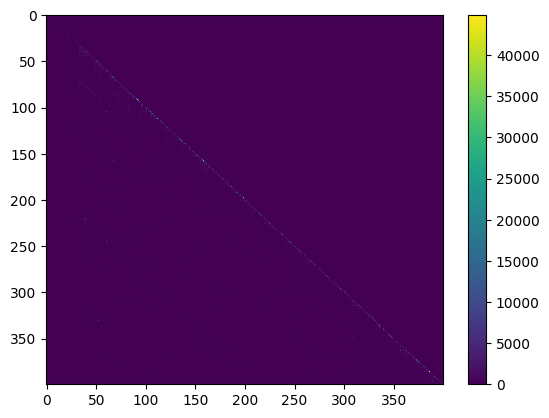

In [43]:
import matplotlib.pyplot as plt
song_id = 1
model.eval()
model.set_downsampled_path_enabled(True)
model.eval()
jacobian = model.get_jacobian(ds[song_id]['indices'][:400].unsqueeze(0).cuda(),ds[song_id]['pos'][:400+1].unsqueeze(0).cuda(),range(0,400))
plt.imshow((jacobian**2).max(dim=2).values.cpu().detach().numpy(),aspect='auto',interpolation='none')
plt.colorbar()



True

In [5]:
ds.ds.get_piano_roll(10).to_midi('output/test.mid')

ticks per beat: 480
max tick: 0
tempo changes: 1
time sig: 0
key sig: 0
markers: 0
lyrics: False
instruments: 1

In [37]:
for i in range(1330,3000):
    print(i)
    pr = ds.ds.get_piano_roll(i)
    l = []
    for i in range(5):
        l.append(pr.notes[i].pitch)
    if len( {36, 48, 52, 55, 62} - set(l)) < 2:
        break


1330
1331
1332
1333
1334
1335
1336
1337
1338
1339
1340
1341
1342
1343
1344
1345
1346
1347
1348
1349
1350
1351
1352
1353
1354
1355
1356
1357
1358
1359
1360
1361
1362
1363
1364
1365
1366


In [38]:
l

[36, 43, 48, 52, 55]

In [32]:
pr.to_midi('output/test.mid')

ticks per beat: 480
max tick: 0
tempo changes: 1
time sig: 0
key sig: 0
markers: 0
lyrics: False
instruments: 1

In [39]:
import random


random.choice(['隨單','戰旗'])

'戰旗'

In [2]:
import torch.nn as nn
nn.transformerenco()

c:\Users\User\miniconda3\envs\gr\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Transformer(
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
    (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (decoder): TransformerDecoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerDecoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, o